## Comparison of PCA of Star-Formation Histories (2D-data) of Massive Galaxies derived from two Bayesian Codes

### Context

We can obtain two types of data of a galaxy - <br>
1. Photometric data (small) 
2. Spectroscopic data (large) 
Bayesian modeling this data will obtain their Star-formation Histories (SFHs) as one of the outputs. <br>

My recent publication focused on comparing the SFHs of these galaxies at 3 physical timestamps, namely - t10, t50 and t90 - corresponding to the times when a galaxy forms 10%, 50% and 90% of its stellar mass. (https://doi.org/10.3847/1538-4357/ad0c4e) <br>

In this notebook, we want to go a step further and systematically study major star formation modes of galaxies of the LEGA-C Survey - **not just at few time-stamps, but across their full lifetime/history.** <br>

For that, we adopt PCA technique described in detail in Sparre+2015 (https://academic.oup.com/mnras/article/447/4/3548/1751599) (inspired by Cohn & Voort 2015). <br>
SFH of a galaxy is seen as a vector in a N-dimensional space. 
As >90% of the information could be represented in first 3 components, we will study PC0, PC1 and PC2 only - they describe scatter around the mean SFH and diagonalize the scatter matrix. <br>
They characterize the most important **modes of star-formation hisotry** <br>

The PC0-mode accounts for galaxies forming stars early or late, depending on whether the coefficient q0 is positive (earlier than sample mean) or negative (later than sample mean) <br>
PC1 and PC2 determine the more detailed evolution of the SFH and cross the zero-point two and three times, respectively. 

In terms of the principal components, the SFHs of a family/population of galaxies can be written as - 


![](eqn.png)

where, <br>
<br>
**\<SFR>** = mean Star-Formation History (SFH) <br>
**_qi_** =  coefficients determining the strength of the contribution of PCi <br>
**PCi** =  principal components of all SFHs in that bin <br>
**N** = number of principal components (we chose 3) 

An example from the Illustris-TNG study in Sparre+2015 shows - 
1. Raw SFHs in 4 stellar mass bins (solid lines) 
2. Principal components PC0, PC1 and PC2 and mean SFH for a sample of galaxies at $ M_{*} = 10^{10} $

Note that higher modes (PC1 and PC2) capture finer variances in SFH. <br>

<div style="display: flex;">
    <img src="ex-sfh.png" alt="Image 2" style="width: 50%;">
    <img src="example.png" alt="Image 1" style="width: 40%;">
</div>

#### NOTE - 

Additionally, we know that q0-value of the PCA decomposed SFH of a galaxy captures whether its stellar population forms _early_ or _late_. <br>
Correlations between q0 and other quantities sensitive to the age of stellar populations is expected. 

### Questions to answer 

We would like to statistically understand the SFHs of population of galaxies in the LEGA-C Survey. <br>
In this notebook, we will compare Principal Components of these galaxies from two Bayesian Modeling tools - BAGPIPES and PROSPECTOR <br>
We would like to answer - <br>
1. How similar / different are Principal Components (PC0, PC1 and PC2) of recovered SFHs from (1) Photometric data (2) Spectro-photometric data. 
2. How much more information does spectroscopic data add to SFHs? 
3. Are the inferences similar/different from the two Bayesian modelings? 
4. How are the properties of galaxies (age, metallicity, dust, ssfr) related to the SFH? 

We chose **BvrizYJ bands** for photometric modeling and **LEGA-C spectra + BvrizYJ bands** for spectro-photometric modeling. <br>


### Data 

1. LEGA-C Spectroscopic data (https://iopscience.iop.org/article/10.3847/1538-4365/ac1356/meta) 
2. UltraVista Photometric data (https://iopscience.iop.org/article/10.1088/0067-0049/206/1/8) 

### Method 

PCA analysis on 2-D SFH data (star-formation rate (SFR) v/s time) <br>
More details in Sparre+2015 https://academic.oup.com/mnras/article/447/4/3548/1751599

In [1]:
# Importing necesary libraries and files 

import numpy as np
import pandas as pd
import os,glob
import bagpipes as pipes
import pygtc
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
from astropy.table import Table,Column
from astropy.io import fits
from scipy.interpolate import interp1d

import os
import sys
from IPython import display

import corner
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.io.fits as fits
import random

from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from scipy import integrate
import matplotlib
import copy
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D   
import matplotlib.patches as mpatches

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
Initialized stellar population with FSPS.


### Loading catalogs and functions from .py files that will be used

In [10]:
from pca_functions import *

### TOOL-1  &ensp; Bagpipes (Bayesian Analysis of Galaxies for Physical Inference and Parameter Estimation) 

In [8]:
# Mentioning path to SFHs
bp_p_sfh_path = '/Users/yashakaushal/Documents/my_papers/paper2/data/bagpipes/p_final_bj/sfh_csv/'
bp_s_sfh_path = '/Users/yashakaushal/Documents/my_papers/paper2/data/bagpipes/s_final_fulldata_bj/sfh_csv/'

# Loading photometric catalog
bp_p_cat = pd.read_csv('/Users/yashakaushal/Documents/legac_19july/crc_loop/p_final_fulldata_bj/yasha_df_ZM.csv')
bp_p_cat.rename(columns={'Unnamed: 0':'idm'},inplace=True)
dustdf = pd.read_csv('/Users/yashakaushal/Documents/legac_19july/crc_loop/p_final_fulldata_bj/dustdf.csv')
dustdf.rename(columns={'Unnamed: 0':'idm'},inplace=True)
bp_p_cat = pd.merge(bp_p_cat,dustdf,on='idm')
bp_p_cat

# Loading spectro-photometric catalog
bp_s_cat = pd.read_csv('/Users/yashakaushal/Documents/my_papers/paper1_sfh/data/s_final_fulldata_bj/bp_only_medians/yasha_df_ZM_1.csv')
bp_s_cat.rename(columns={'Unnamed: 0':'idm'},inplace=True)


In [5]:
# Loading photometric modeling outputs 
# contains properties like metallicity, mass, formation time, dust etc for each galaxy in the LEGA-C survey

bp_p_cat.head()

idm    Zper16    Zper50    Zper84     Zerrl     Zerru     Mper16  \
0  101089+12  0.114026  0.394793  1.497030  0.280767  1.102238  10.892399   
1  101221+18  0.381780  1.452966  2.164621  1.071186  0.711655  10.973558   
2   101262+2  0.341969  0.867132  1.708952  0.525163  0.841820  10.491820   
3  101401+18  0.957563  1.660645  2.201758  0.703081  0.541113  10.935165   
4   101415+2  0.866794  1.514068  2.122137  0.647274  0.608069  11.157455   

      Mper50     Mper84     Merrl  ...     ssfr50   tform50   tform16  \
0  11.043042  11.189150  0.296751  ... -20.608976  3.304797  1.911174   
1  11.064010  11.212803  0.239246  ... -19.809994  5.073120  4.855319   
2  10.601991  10.720571  0.228751  ...  -9.631560  4.533716  4.006174   
3  11.055317  11.198233  0.263069  ...  -9.433867  3.676707  3.114049   
4  11.264105  11.378038  0.220583  ...  -9.516685  3.400019  3.107375   

    tform84  tquench50  tquench16  tquench84      Av16      Av50      Av84  
0  4.809765   5.313788   3.681919   5.935242  0.385771  0.783942  1.188418  
1  5.215737   5.315195   5.127791   5.519490  0.652814  0.935620  1.365664  
2  5.674631  99.000000  99.000000  99.000000  1.186725  1.467440  1.787443  
3  4.484368  99.000000  99.000000  99.000000  0.856363  1.206483  1.619951  
4  4.207124  99.000000  99.000000  99.000000  1.147153  1.431533  1.750612  

[5 rows x 35 columns]

In [7]:
# Loading spectrophotometric modeling outputs 
# contains properties like metallicity, mass, formation time, dust etc for each galaxy in the LEGA-C survey

bp_s_cat.head()

idm    Zper16    Zper50    Zper84     Zerrl     Zerru     Mper16  \
0  101089+12  0.500169  0.662911  0.864685  0.162742  0.201775  10.934122   
1  101221+18  0.402532  0.422007  0.460523  0.019476  0.038516  11.154486   
2   101262+2  0.168916  0.196831  0.233156  0.027915  0.036325  10.616203   
3  101401+18  1.409736  1.913125  2.311935  0.503389  0.398810  10.973759   
4   101415+2  0.806981  1.213160  1.922875  0.406179  0.709715  11.031448   

      Mper50     Mper84     Merrl  ...  tquench84      Av16      Av50  \
0  11.018801  11.126816  0.192694  ...   5.379914  0.280997  0.437939   
1  11.199233  11.267245  0.112759  ...   4.749419  0.229455  0.321219   
2  10.704185  10.782214  0.166010  ...  99.000000  1.620707  1.796412   
3  11.073751  11.196505  0.222746  ...  99.000000  0.925568  1.190144   
4  11.147357  11.275872  0.244424  ...  99.000000  0.783112  0.997951   

       Av84       n16       n50       n84       sig16       sig50       sig84  
0  0.701522  0.451263  0.690178  0.932098  171.302952  188.198016  207.149110  
1  0.459376  0.646758  0.909537  1.169195  215.059301  226.700134  238.540010  
2  1.921916  0.699383  0.778508  0.863152   47.685763   64.216503   88.564511  
3  1.510139  0.593322  0.722034  0.879063  129.888250  144.825006  159.389975  
4  1.268574  0.666434  0.837981  1.004191  137.103721  144.938696  153.983291  

[5 rows x 41 columns]

### Bagpipes: Photometry-only data

#### Saving MEDIAN SFH information in dataframes

In [14]:
# Storing MEDIAN SFH information of each galaxy in bins of stellar mass and separately for Star-forming (uvjsf==0) and Quiescent (uvjsf==1) galaxies 

idmlist = bp_p_cat['idm']
mmin = [10.5,11,11.5,10.5,11,11.5]
mmax = [11,11.5,12,11,11.5,12]
uvjsf = [0,0,0,1,1,1]
names = ['pdf1lb','pdf2lb','pdf3lb','pdf4lb','pdf5lb','pdf6lb']

for mmin,mmax,uvjsf,name in list(zip(mmin,mmax,uvjsf,names)):
    
    cut = (bp_p_cat.Mper50>mmin) & (bp_p_cat.Mper50<mmax) & (bp_p_cat.uvjsf==uvjsf)
    idmlist = np.array(bp_p_cat['idm'][cut])
    df = pd.DataFrame(columns=['sfh'+str(i) for i in range(len(idmlist))])
    age_grid = np.linspace(0.01,8,2000)
    df['ages'] = age_grid
    
    for i in range(len(idmlist)):
        try:
            idm = idmlist[i]
            sfh = pd.read_csv(bp_p_sfh_path+'sfh_%s.csv'%idm,header=None)
            sfh.drop(columns=0,inplace=True)
            ages = np.array(sfh.loc[0,:])
            sfh50 = np.nanpercentile(sfh,50,axis=0)
            z = get_redshift(idm)
            t0 = cosmo.age(z).value
            f2 = interp1d(t0-ages,sfh50,kind='linear',fill_value=(0,0),bounds_error=False)  # interpolating on common age grid
            s2 = f2(age_grid)
            df.iloc[:,i] = s2

        except FileNotFoundError:
            pass

    df.to_csv(bp_p_sfh_path + '../dfs/' + name + '.csv')

In [29]:
# Example of saved dataframe (note ages are in the last column) 
pd.read_csv(bp_p_sfh_path + '../dfs/' + 'pdf1lb.csv',index_col=0).head()

sfh0       sfh1      sfh2      sfh3       sfh4       sfh5       sfh6  \
0  5.117500  24.572116  9.833490  9.794649  12.039040  11.488778  18.000657   
1  5.117586  24.573200  9.834251  9.794837  12.038403  11.488994  18.001121   
2  5.117671  24.574285  9.835011  9.795025  12.037766  11.489211  18.001584   
3  5.117757  24.575370  9.835772  9.795213  12.037129  11.489427  18.002046   
4  5.117842  24.576456  9.836534  9.795401  12.036491  11.490443  18.002506   

        sfh7       sfh8       sfh9  ...     sfh553    sfh554    sfh555  \
0  16.372752  10.066403  14.810421  ...  10.925393  6.877807  8.497954   
1  16.370180  10.067180  14.811195  ...  10.925513  6.877204  8.498430   
2  16.367602  10.066671  14.811878  ...  10.925633  6.876601  8.498906   
3  16.365019  10.066160  14.812560  ...  10.925753  6.876093  8.499382   
4  16.362430  10.065650  14.813243  ...  10.925873  6.876101  8.503777   

     sfh556     sfh557     sfh558    sfh559    sfh560     sfh561      ages  
0  8.085873  11.926866  51.779200  6.914065  7.875480  31.765234  0.010000  
1  8.087179  11.927239  51.778149  6.917783  7.876950  31.766022  0.013997  
2  8.087922  11.927613  51.776996  6.921505  7.878421  31.766811  0.017994  
3  8.087965  11.927986  51.775739  6.925232  7.879893  31.767600  0.021991  
4  8.088008  11.928360  51.774378  6.928962  7.881365  31.768389  0.025988  

[5 rows x 563 columns]

### Bagpipes: Spectro-photometric data

#### Saving MEDIAN SFH information in dataframes

In [1096]:
# Repeating the same for SFHs recovered from spectro-photometric data
# Storing SFH information of each galaxy in bins of stellar mass and type of galaxy - Star-forming (uvjsf==0) and Quiescent (uvjsf==1)

idmlist = bp_cat['idm']
mmin = [10.5,11,11.5,10.5,11,11.5]
mmax = [11,11.5,12,11,11.5,12]
uvjsf = [0,0,0,1,1,1]
names = ['df1lb','df2lb','df3lb','df4lb','df5lb','df6lb']

for mmin,mmax,uvjsf,name in list(zip(mmin,mmax,uvjsf,names)):
    
    cut = (bp_cat.Mper50>mmin) & (bp_cat.Mper50<mmax) & (bp_cat.uvjsf==uvjsf) # looping in bins of mass and galaxy type 
    idmlist = np.array(bp_cat['idm'][cut])
    df = pd.DataFrame(columns=['sfh_' + i for i in (idmlist.astype(str))])
    age_grid = np.linspace(0.01,8,2000)
    df['ages'] = age_grid
    
    for i in range(len(idmlist)):
        try:
            idm = idmlist[i]
            sfh = pd.read_csv(bp_sfh_path+'sfh_%s.csv'%idm,header=None)
            sfh.drop(columns=0,inplace=True)
            ages = np.array(sfh.loc[0,:])
            sfh50 = np.nanpercentile(sfh,50,axis=0)
            z = get_redshift(idm)
            t0 = cosmo.age(z).value
            f2 = interp1d(t0-ages,sfh50,kind='linear',fill_value=(0,0),bounds_error=False)  #interpolating on common age grid
            s2 = f2(age_grid)
            df.iloc[:,i] = s2

        except FileNotFoundError:
            pass

    df.to_csv(bp_s_sfh_path + '../dfs/' + name + '.csv') # note path changed to spec+phot directory 



#### Reading SFH dataframes from the two models

In [18]:
# Loading above dataframes 

df1lb = pd.read_csv(bp_p_sfh_path + '../dfs/pdf1lb.csv')  # SF
df2lb = pd.read_csv(bp_p_sfh_path + '../dfs/pdf2lb.csv')  # SF
df3lb = pd.read_csv(bp_p_sfh_path + '../dfs/pdf3lb.csv')  # SF
df4lb = pd.read_csv(bp_p_sfh_path + '../dfs/pdf4lb.csv')  # Q
df5lb = pd.read_csv(bp_p_sfh_path + '../dfs/pdf5lb.csv')  # Q
df6lb = pd.read_csv(bp_p_sfh_path + '../dfs/pdf6lb.csv')  # Q


df1lbs = pd.read_csv(bp_s_sfh_path + '../dfs/df1lb.csv') # SF
df2lbs = pd.read_csv(bp_s_sfh_path + '../dfs/df2lb.csv') # SF
df3lbs = pd.read_csv(bp_s_sfh_path + '../dfs/df3lb.csv') # SF
df4lbs = pd.read_csv(bp_s_sfh_path + '../dfs/df4lb.csv') # Q
df5lbs = pd.read_csv(bp_s_sfh_path + '../dfs/df5lb.csv') # Q
df6lbs = pd.read_csv(bp_s_sfh_path + '../dfs/df6lb.csv') # Q


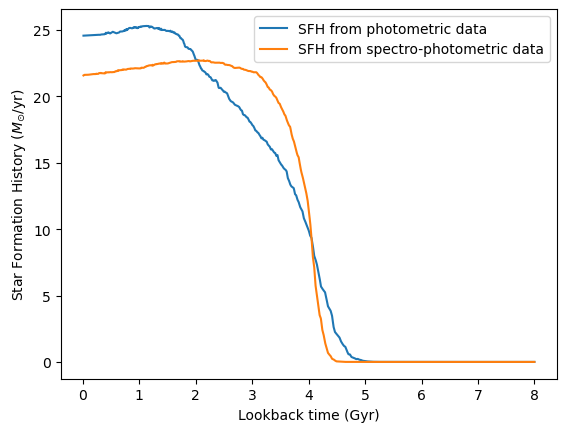

In [28]:
# Example SFH to check values stored in the dataframes

age_grid = df1lb.ages
plt.plot(age_grid,df1lb.iloc[:,2],label='SFH from photometric data') # SFH from photometric data
plt.plot(age_grid,df1lbs.iloc[:,2],label='SFH from spectro-photometric data') # SFH from spectro-photometric data
plt.xlabel('Lookback time (Gyr)') 
plt.ylabel('Star Formation History ($M_{\odot}$/yr)')
plt.legend()

Text(0.5, 0.98, 'All Star-Formation Histories from two models in Stellar Mass bins \n for Star-Forming Galaxies in Bagpipes')

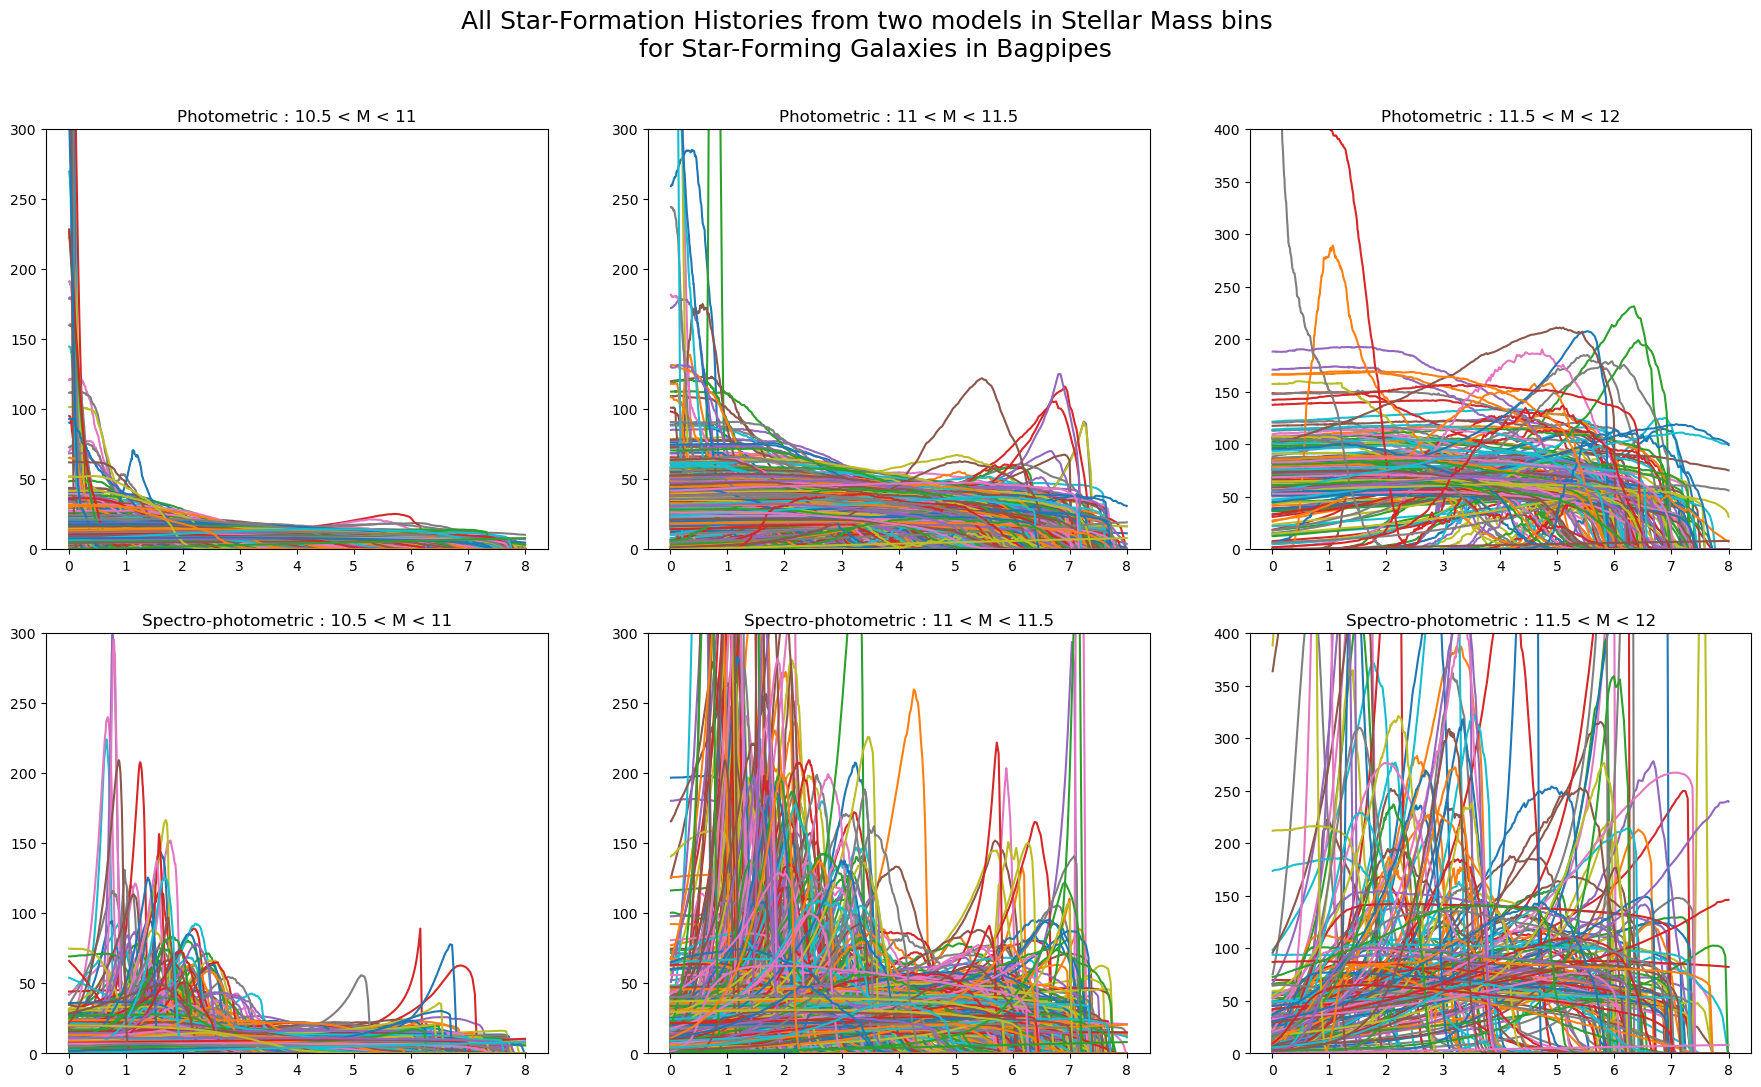

In [45]:
# Plotting all SFHs of Star-forming galaxies in Bagpipes

fig, axes = plt.subplots(2,3,figsize=(22,12),sharex=False)
ax = axes.flatten()

# SFH from photometric data

for i in range(1,df1lb.shape[1]):
    ax[0].plot(age_grid,df1lb.iloc[:,i])

for i in range(1,df2lb.shape[1]):
    ax[1].plot(age_grid,df2lb.iloc[:,i])

for i in range(1,df3lb.shape[1]):
    ax[2].plot(age_grid,df3lb.iloc[:,i])
    
# SFH from spectro-photometric data
 
for i in range(1,df1lbs.shape[1]):
    ax[3].plot(age_grid,df1lbs.iloc[:,i])

for i in range(1,df2lbs.shape[1]):
    ax[4].plot(age_grid,df2lbs.iloc[:,i])

for i in range(1,df3lbs.shape[1]):
    ax[5].plot(age_grid,df3lbs.iloc[:,i])

ax[0].set_title('Photometric : 10.5 < M < 11') 
ax[1].set_title('Photometric : 11 < M < 11.5') 
ax[2].set_title('Photometric : 11.5 < M < 12') 

ax[3].set_title('Spectro-photometric : 10.5 < M < 11') 
ax[4].set_title('Spectro-photometric : 11 < M < 11.5') 
ax[5].set_title('Spectro-photometric : 11.5 < M < 12') 

ax[0].set_ylim(0,300)
ax[3].set_ylim(0,300)

ax[1].set_ylim(0,300)
ax[4].set_ylim(0,300)

ax[2].set_ylim(0,400)
ax[5].set_ylim(0,400)


# fig.subplots_adjust(hspace=0.2,wspace=0.3)

fig.suptitle('All Star-Formation Histories from two models in Stellar Mass bins \n for Star-Forming Galaxies in Bagpipes',y=0.98,fontsize=18)

Text(0.5, 0.98, 'All Star-Formation Histories from two models in Stellar Mass bins \n for Quiescent Galaxies in Bagpipes')

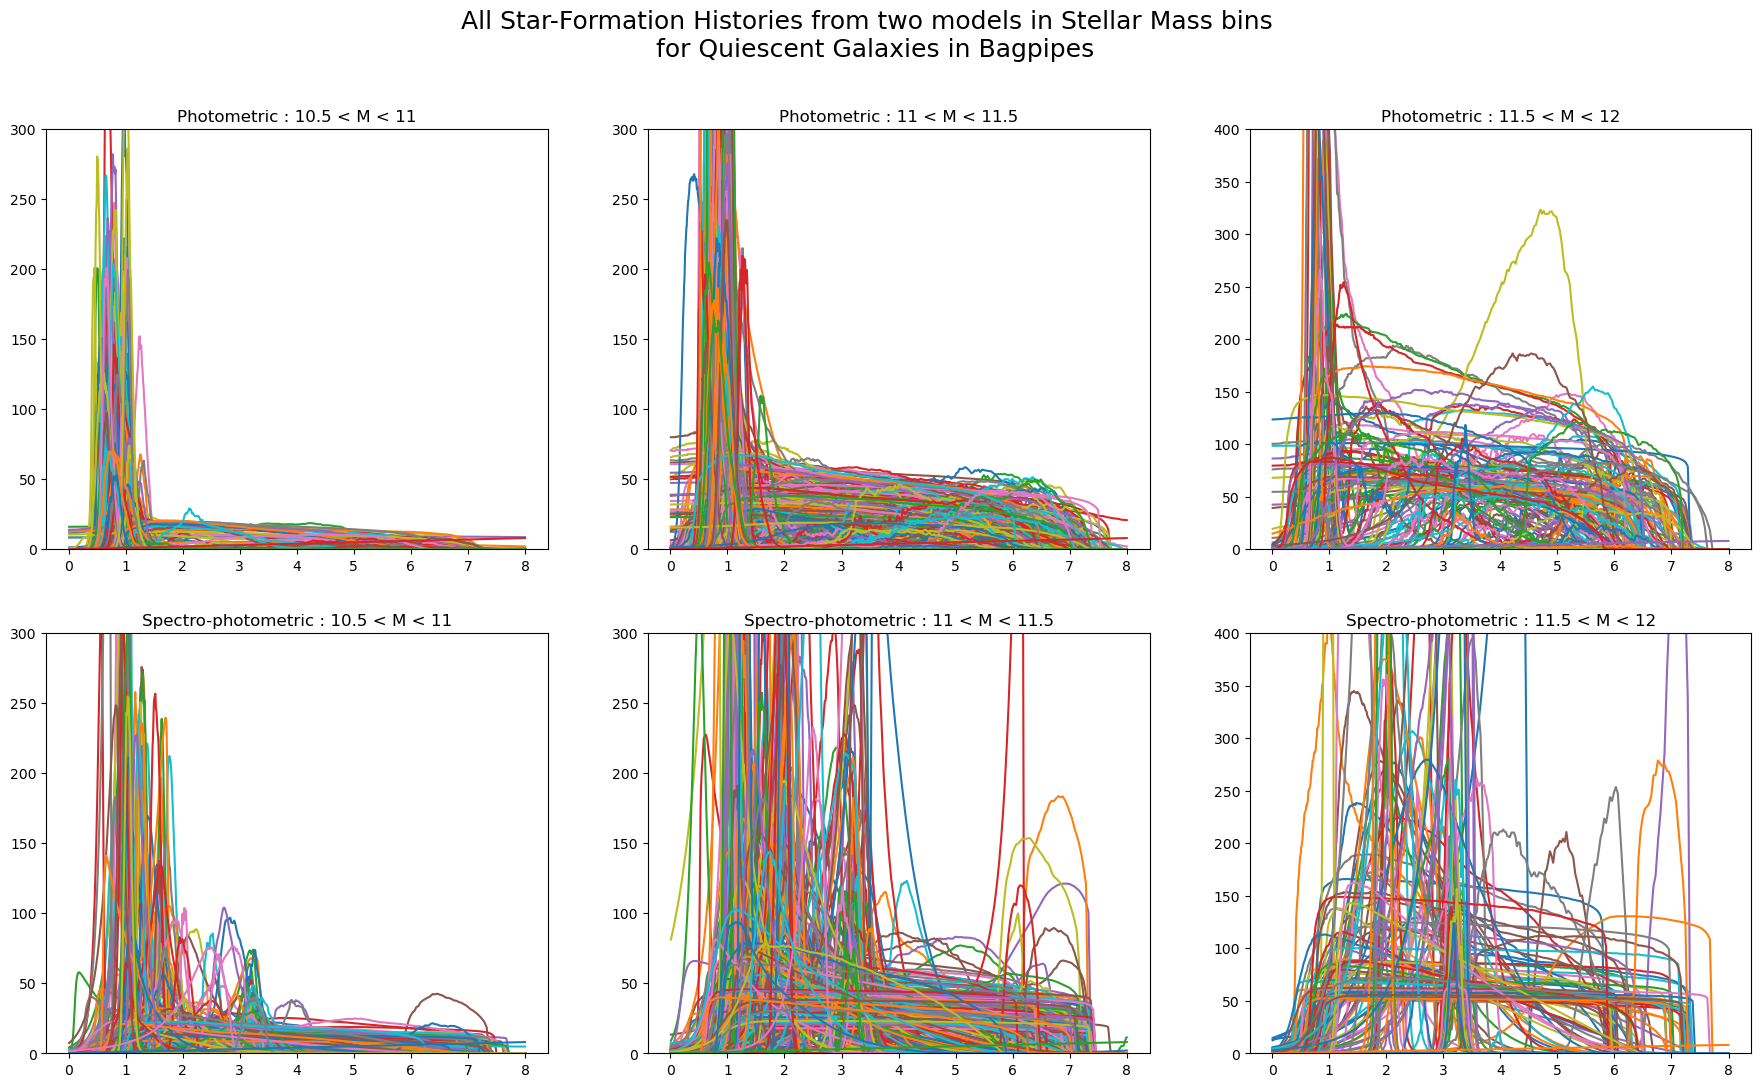

In [46]:
# Plotting all SFHs of Quiescent galaxies in Bagpipes

fig, axes = plt.subplots(2,3,figsize=(22,12),sharex=False)
ax = axes.flatten()

# SFH from photometric data

for i in range(1,df4lb.shape[1]):
    ax[0].plot(age_grid,df4lb.iloc[:,i])

for i in range(1,df5lb.shape[1]):
    ax[1].plot(age_grid,df5lb.iloc[:,i])

for i in range(1,df6lb.shape[1]):
    ax[2].plot(age_grid,df6lb.iloc[:,i])
    
# SFH from spectro-photometric data
 
for i in range(1,df4lbs.shape[1]):
    ax[3].plot(age_grid,df4lbs.iloc[:,i])

for i in range(1,df5lbs.shape[1]):
    ax[4].plot(age_grid,df5lbs.iloc[:,i])

for i in range(1,df6lbs.shape[1]):
    ax[5].plot(age_grid,df6lbs.iloc[:,i])

ax[0].set_title('Photometric : 10.5 < M < 11') 
ax[1].set_title('Photometric : 11 < M < 11.5') 
ax[2].set_title('Photometric : 11.5 < M < 12') 

ax[3].set_title('Spectro-photometric : 10.5 < M < 11') 
ax[4].set_title('Spectro-photometric : 11 < M < 11.5') 
ax[5].set_title('Spectro-photometric : 11.5 < M < 12') 

ax[0].set_ylim(0,300)
ax[3].set_ylim(0,300)

ax[1].set_ylim(0,300)
ax[4].set_ylim(0,300)

ax[2].set_ylim(0,400)
ax[5].set_ylim(0,400)


# fig.subplots_adjust(hspace=0.2,wspace=0.3)

fig.suptitle('All Star-Formation Histories from two models in Stellar Mass bins \n for Quiescent Galaxies in Bagpipes',y=0.98,fontsize=18)

#### Performing PCA analysis (3 components) and saving coefficients in a file 

In [48]:
# Photometry only data

ncomp = 3

dft1 = pd.DataFrame(data=df1lb.iloc[:,1:-1])
dft1.dropna(axis=1,inplace = True)
pca1 = PCA(n_components=ncomp)
pca1.fit(dft1.T)
(pca1.components_)[0]

dft2 = pd.DataFrame(data=df2lb.iloc[:,1:-1])
dft2.dropna(axis=1,inplace = True)
pca2 = PCA(n_components=ncomp)
pca2.fit(dft2.T)
(pca2.components_)[0]

dft3 = pd.DataFrame(data=df3lb.iloc[:,1:-1])
dft3.dropna(axis=1,inplace = True)
pca3 = PCA(n_components=ncomp)
pca3.fit(dft3.T)
(pca3.components_)[0]

dft4 = pd.DataFrame(data=df4lb.iloc[:,1:-1])
dft4.dropna(axis=1,inplace = True)
pca4 = PCA(n_components=ncomp)
pca4.fit(dft4.T)
(pca4.components_)[0]

dft5 = pd.DataFrame(data=df5lb.iloc[:,1:-1])
dft5.dropna(axis=1,inplace = True)
pca5 = PCA(n_components=ncomp)
pca5.fit(dft5.T)
(pca5.components_)[0]

dft6 = pd.DataFrame(data=df6lb.iloc[:,1:-1])
dft6.dropna(axis=1,inplace = True)
pca6 = PCA(n_components=ncomp)
pca6.fit(dft6.T)
(pca6.components_)[0]

(pca1.components_)[0]

array([ 2.51284988e-01,  2.47037788e-01,  2.42060653e-01, ...,
       -7.32144538e-05, -7.24862920e-05, -7.17581303e-05])

In [49]:
# Saving PCA coefficient values (q0,q1,q3) in dataframes

# fitting y = m1x1 + m2x2 + m3x3 + <sfh>
def func(x, m1, m2, m3):
    return (m1*x[0] + m2*x[1] + m3*x[2] + avg)

cols = ['q0','q1','q2']
dfs = [dft1,dft2,dft3,dft4,dft5,dft6]
pcas = [pca1,pca2,pca3,pca4,pca5,pca6]
qdfid = ['sf1','sf2','sf3','q1','q2','q3']
mmin = [10.5,11,11.5,10.5,11,11.5]
mmax = [11,11.5,12,11,11.5,12]
uvj = [0,0,0,1,1,1]

uvjsf=[]
for i in bp_p_cat.idm.to_list():
    uvjsf.append(nscat['UVJ_SFQ'][nscat.idm==i].iloc[0])

bp_p_cat['uvjsf'] = uvjsf

for df,pca,qid,mmin,mmax,uvj in list(zip(dfs,pcas,qdfid,mmin,mmax,uvj)):

    cut = (bp_p_cat.Mper50>mmin) & (bp_p_cat.Mper50<mmax) & (bp_p_cat.uvjsf==uvj)
    idmlist = np.array(bp_p_cat['idm'][cut])

    # same for each dataframe
    x1 = pca.components_[0]
    x2 = pca.components_[1]
    x3 = pca.components_[2]
    x = [x1,x2,x3]
    avg = np.mean(df,axis=1)/df.shape[1]
    qvals = pd.DataFrame(columns = cols,index=idmlist)


    for i in range(df.shape[1]-2):
        y = list(df.iloc[:,i+1])
        idm = idmlist[i]
        popt, pcov = curve_fit(func, x, y)
        qvals.iloc[i,:] = [popt[0],popt[1],popt[2]]

    qvals['idm'] = qvals.index
    qvals = pd.merge(qvals,bp_p_cat,on='idm')
    qvals.to_csv('/Users/yashakaushal/Documents/my_papers/paper2/data/bagpipes/p_final_bj/PCA_bj/q_values_merged/%s.csv'%qid)


In [51]:
# Spectro-photometric data

ncomp = 3

dft1s = pd.DataFrame(data=df1lbs.iloc[:,1:-1])
dft1s.dropna(axis=1,inplace = True)
pca1s = PCA(n_components=ncomp)
pca1s.fit(dft1s.T)
(pca1s.components_)[0]

dft2s = pd.DataFrame(data=df2lbs.iloc[:,1:-1])
dft2s.dropna(axis=1,inplace = True)
pca2s = PCA(n_components=ncomp)
pca2s.fit(dft2s.T)
(pca2s.components_)[0]

dft3s = pd.DataFrame(data=df3lbs.iloc[:,1:-1])
dft3s.dropna(axis=1,inplace = True)
pca3s = PCA(n_components=ncomp)
pca3s.fit(dft3s.T)
(pca3s.components_)[0]

dft4s = pd.DataFrame(data=df4lbs.iloc[:,1:-1])
dft4s.dropna(axis=1,inplace = True)
pca4s = PCA(n_components=ncomp)
pca4s.fit(dft4s.T)
(pca4s.components_)[0]

dft5s = pd.DataFrame(data=df5lbs.iloc[:,1:-1])
dft5s.dropna(axis=1,inplace = True)
pca5s = PCA(n_components=ncomp)
pca5s.fit(dft5s.T)
(pca5s.components_)[0]

dft6s = pd.DataFrame(data=df6lbs.iloc[:,1:-1])
dft6s.dropna(axis=1,inplace = True)
pca6s = PCA(n_components=ncomp)
pca6s.fit(dft6s.T)
(pca6s.components_)[0]

(pca1s.components_)[0]

array([ 0.01337041,  0.01342059,  0.01347422, ..., -0.00038434,
       -0.00037957, -0.00037479])

In [59]:
# Saving PCA coefficient values (q0,q1,q3) in dataframes

# fitting y = m1x1 + m2x2 + m3x3 + <sfh>
def func(x, m1, m2, m3):
    return (m1*x[0] + m2*x[1] + m3*x[2] + avg)

cols = ['q0','q1','q2']
dfs = [dft1s,dft2s,dft3s,dft4s,dft5s,dft6s]
pcas = [pca1s,pca2s,pca3s,pca4s,pca5s,pca6s]
qdfid = ['sf1s','sf2s','sf3s','q1s','q2s','q3s']
mmin = [10.5,11,11.5,10.5,11,11.5]
mmax = [11,11.5,12,11,11.5,12]
uvj = [0,0,0,1,1,1]

uvjsf=[]
for i in bp_s_cat.idm.to_list():
    uvjsf.append(nscat['UVJ_SFQ'][nscat.idm==i].iloc[0])

bp_s_cat['uvjsf'] = uvjsf

for df,pca,qid,mmin,mmax,uvj in list(zip(dfs,pcas,qdfid,mmin,mmax,uvj)):

    cut = (bp_s_cat.Mper50>mmin) & (bp_s_cat.Mper50<mmax) & (bp_s_cat.uvjsf==uvj)
    idmlist = np.array(bp_s_cat['idm'][cut])

    # same for each dataframe
    x1 = pca.components_[0]
    x2 = pca.components_[1]
    x3 = pca.components_[2]
    x = [x1,x2,x3]
    avg = np.mean(df,axis=1)/df.shape[1]
    ids = [col.split('_')[1] for col in df.columns]  # from column names
    qvals = pd.DataFrame(columns = cols,index=ids)

    for i,j in enumerate(ids):
        y = list(df.iloc[:,i])
        idm = j
        popt, pcov = curve_fit(func, x, y)
        qvals.iloc[i,:] = [popt[0],popt[1],popt[2]]

    qvals['idm'] = qvals.index
    qvals = pd.merge(qvals,bp_s_cat,on='idm')
    qvals.to_csv('/Users/yashakaushal/Documents/my_papers/paper2/data/bagpipes/s_final_fulldata_bj/PCA_bj/q_values_merged/%s.csv'%qid)


### Plotting the principle components of SFH recovered from (1) Photometric data (2) Spectrophotometric data in one figure 

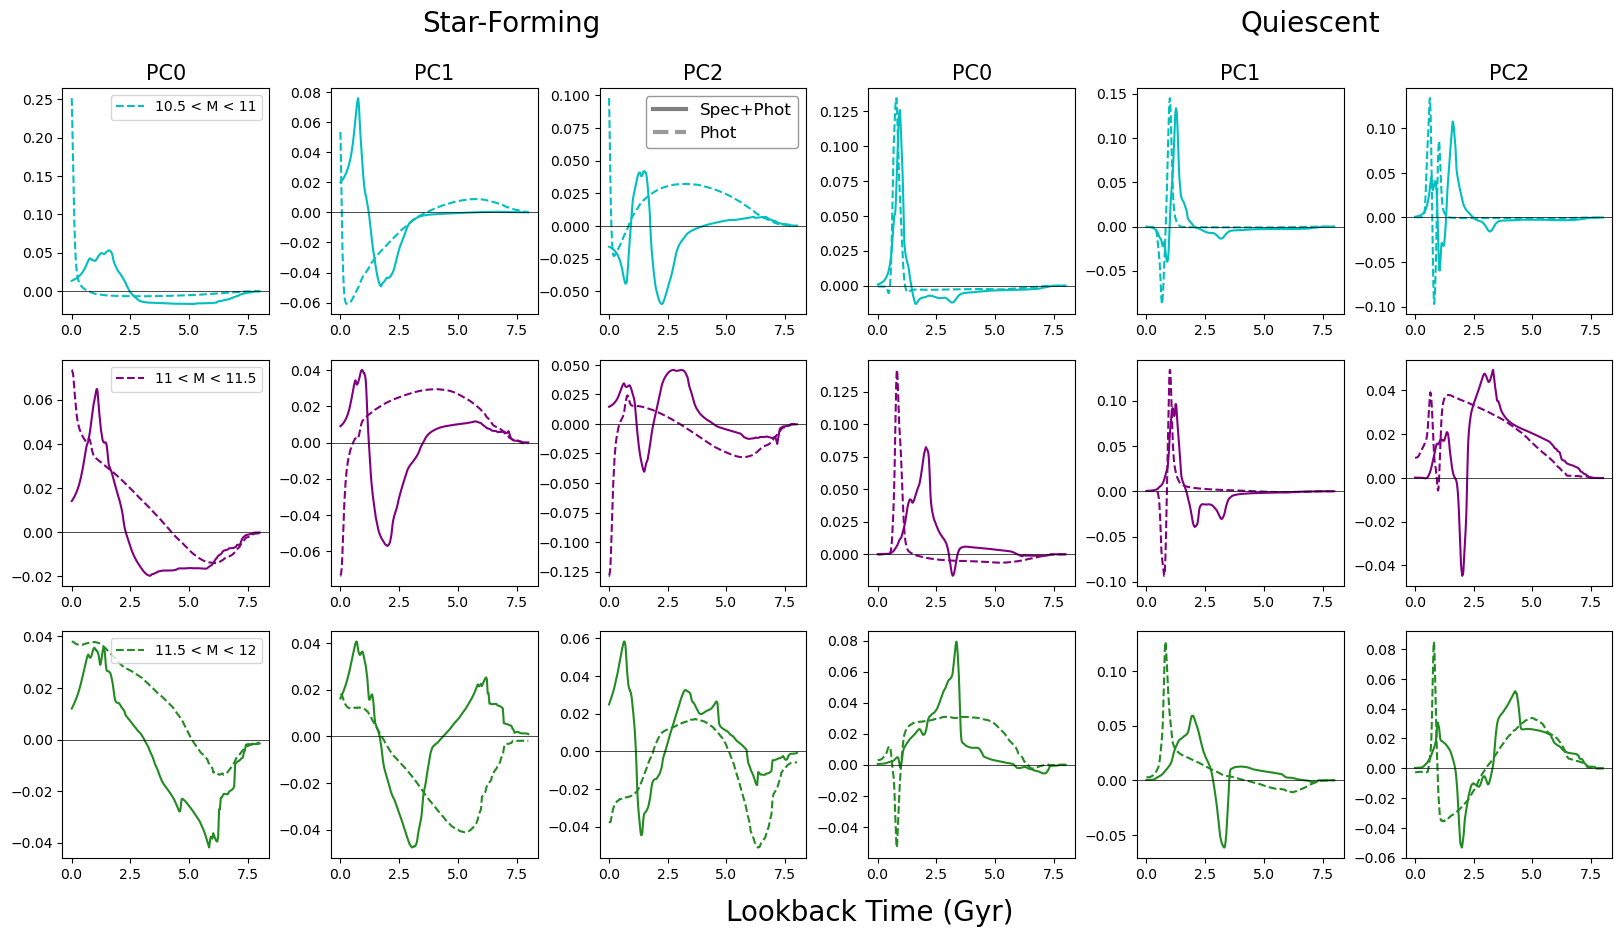

In [72]:
# in lookback time 
fig, axes = plt.subplots(3,6,figsize=(20,10),sharex=False)
ax = axes.flatten()

lsp = '--'
lss = '-'
alpha=1
colors=['c','purple','forestgreen']

# SF ======

ax[0].plot(age_grid,(pca1.components_)[0],label='10.5 < M < 11',linestyle=lsp,color=colors[0])
ax[1].plot(age_grid,-1*(pca1.components_)[1],linestyle=lsp,color=colors[0])
ax[2].plot(age_grid,(pca1.components_)[2],linestyle=lsp,color=colors[0])

ax[6].plot(age_grid,(pca2.components_)[0],label='11 < M < 11.5',linestyle=lsp,color=colors[1])
ax[7].plot(age_grid,-1*(pca2.components_)[1],linestyle=lsp,color=colors[1])
ax[8].plot(age_grid,-1*(pca2.components_)[2],linestyle=lsp,color=colors[1])

ax[12].plot(age_grid,(pca3.components_)[0],label='11.5 < M < 12',linestyle=lsp,color=colors[2])
ax[13].plot(age_grid,(pca3.components_)[1],linestyle=lsp,color=colors[2])
ax[14].plot(age_grid,-1*(pca3.components_)[2],linestyle=lsp,color=colors[2])

ax[0].plot(age_grid,(pca1s.components_)[0],linestyle=lss,color=colors[0])
ax[1].plot(age_grid,(pca1s.components_)[1],linestyle=lss,color=colors[0])
ax[2].plot(age_grid,-1*(pca1s.components_)[2],linestyle=lss,color=colors[0])

ax[6].plot(age_grid,(pca2s.components_)[0],linestyle=lss,color=colors[1],alpha=alpha)
ax[7].plot(age_grid,(pca2s.components_)[1],linestyle=lss,color=colors[1],alpha=alpha)
ax[8].plot(age_grid,(pca2s.components_)[2],linestyle=lss,color=colors[1],alpha=alpha)

ax[12].plot(age_grid,-1*(pca3s.components_)[0],linestyle=lss,color=colors[2],alpha=alpha)
ax[13].plot(age_grid,(pca3s.components_)[1],linestyle=lss,color=colors[2],alpha=alpha)
ax[14].plot(age_grid,(pca3s.components_)[2],linestyle=lss,color=colors[2],alpha=alpha)


# Q =============
ax[3].plot(age_grid,(pca4.components_)[0],label='10.5 < M < 11',linestyle=lsp,color=colors[0])
ax[4].plot(age_grid,(pca4.components_)[1],linestyle=lsp,color=colors[0])
ax[5].plot(age_grid,(pca4.components_)[2],linestyle=lsp,color=colors[0])

ax[9].plot(age_grid,(pca5.components_)[0],label='11 < M < 11.5',linestyle=lsp,color=colors[1])
ax[10].plot(age_grid,(pca5.components_)[1],linestyle=lsp,color=colors[1])
ax[11].plot(age_grid,(pca5.components_)[2],linestyle=lsp,color=colors[1])

ax[15].plot(age_grid,(pca6.components_)[0],label='11.5 < M < 12',linestyle=lsp,color=colors[2])
ax[16].plot(age_grid,(pca6.components_)[1],linestyle=lsp,color=colors[2])
ax[17].plot(age_grid,(pca6.components_)[2],linestyle=lsp,color=colors[2])

ax[3].plot(age_grid,(pca4s.components_)[0],linestyle=lss,color=colors[0])
ax[4].plot(age_grid,(pca4s.components_)[1],linestyle=lss,color=colors[0])
ax[5].plot(age_grid,(pca4s.components_)[2],linestyle=lss,color=colors[0])

ax[9].plot(age_grid,(pca5s.components_)[0],linestyle=lss,color=colors[1],alpha=alpha)
ax[10].plot(age_grid,(pca5s.components_)[1],linestyle=lss,color=colors[1],alpha=alpha)
ax[11].plot(age_grid,(pca5s.components_)[2],linestyle=lss,color=colors[1],alpha=alpha)

ax[15].plot(age_grid,(pca6s.components_)[0],linestyle=lss,color=colors[2],alpha=alpha)
ax[16].plot(age_grid,-1*(pca6s.components_)[1],linestyle=lss,color=colors[2],alpha=alpha)
ax[17].plot(age_grid,(pca6s.components_)[2],linestyle=lss,color=colors[2],alpha=alpha)


for i in (0,6,12):
    ax[i].legend(fontsize=10)
    
for i in range(0,18):
    ax[i].axhline(0,ls='-',color='k',lw=0.5)
    
f = 15    
ax[0].set_title('PC0',fontsize=f)
ax[1].set_title('PC1',fontsize=f)
ax[2].set_title('PC2',fontsize=f)

ax[3].set_title('PC0',fontsize=f)
ax[4].set_title('PC1',fontsize=f)
ax[5].set_title('PC2',fontsize=f)

ax[1].text(3.5,0.12,'Star-Forming',fontsize=f+5)
ax[4].text(4,0.22,'Quiescent',fontsize=f+5)
ax[14].text(5,-0.09,'Lookback Time (Gyr)',fontsize=f+5)

fig.subplots_adjust(hspace=0.2,wspace=0.3)

handles, labels = plt.gca().get_legend_handles_labels()

line1 = Line2D([0], [0], label='Spec+Phot', color='grey',linestyle='-',marker='',linewidth = 3,markersize=10)
line2 = Line2D([0], [0], label='Phot', color='grey',linestyle='dashed',linewidth = 3,alpha=0.8)
patch1 = mpatches.Patch(color=colors[0], label='10.5 < M < 11')
patch2 = mpatches.Patch(color=colors[1], label='11 < M < 11.5')
patch3 = mpatches.Patch(color=colors[2], label='11.5 < M < 12')

handles.extend([line1,line2])

leg = ax[2].legend(handles=handles,fontsize=12,loc='upper right',markerscale=1.3,frameon=True,edgecolor='grey')

# fig.savefig('/Users/yashakaushal/Documents/my_papers/paper2/plots/uglyplots/p_pca_comps.pdf',bbox_inches='tight')


### NOTE - 
1. Principle components represent the direction in the feature space along which the data varies the most. PC0 captures the maximum variance in the data. 
2. Notice how SFHs from photometry only data (dotted curves) are not able to recover higher moments of SFH as spectro-photometric data does (solid curve). 

### Checking dependency of _median_ galaxy properties (Age, Metallicity, Formation times) on PC0 SFH 

In [ ]:
# Bagpipes 

lsp = '--'
lss = '-'
alpha=1
colors=['c','purple','forestgreen']

path_s = '/Users/yashakaushal/Documents/my_papers/paper2/data/bagpipes/s_final_fulldata_bj/PCA_bj/q_values_merged/'  # bagpipes
path_p = '/Users/yashakaushal/Documents/my_papers/paper2/data/bagpipes/p_final_bj/PCA_bj/q_values_merged/'  # bagpipes

# path_pall = '/Users/yashakaushal/Documents/my_papers/paper2/data/prospector/p_all/PCA_all/q_values_merged/'  # prospector
# path_sbj = '/Users/yashakaushal/Documents/my_papers/paper2/data/prospector/spec_phot_bj/PCA_bj/q_values_merged/'  # prospector

qq1 = pd.read_csv(path_p + 'q1.csv') # quiescent - phot only 
qq2 = pd.read_csv(path_p + 'q2.csv')
qq3 = pd.read_csv(path_p + 'q3.csv')

qq1s = pd.read_csv(path_s + 'q1s.csv') # quiescent - with spectra
qq2s = pd.read_csv(path_s + 'q2s.csv')
qq3s = pd.read_csv(path_s + 'q3s.csv')

qs1 = pd.read_csv(path_p + 'sf1.csv')  # star-forming - phot only 
qs2 = pd.read_csv(path_p + 'sf2.csv')
qs3 = pd.read_csv(path_p + 'sf3.csv')

qs1s = pd.read_csv(path_s + 'sf1s.csv')  # star-forming - with spectra
qs2s = pd.read_csv(path_s + 'sf2s.csv')
qs3s = pd.read_csv(path_s + 'sf3s.csv')


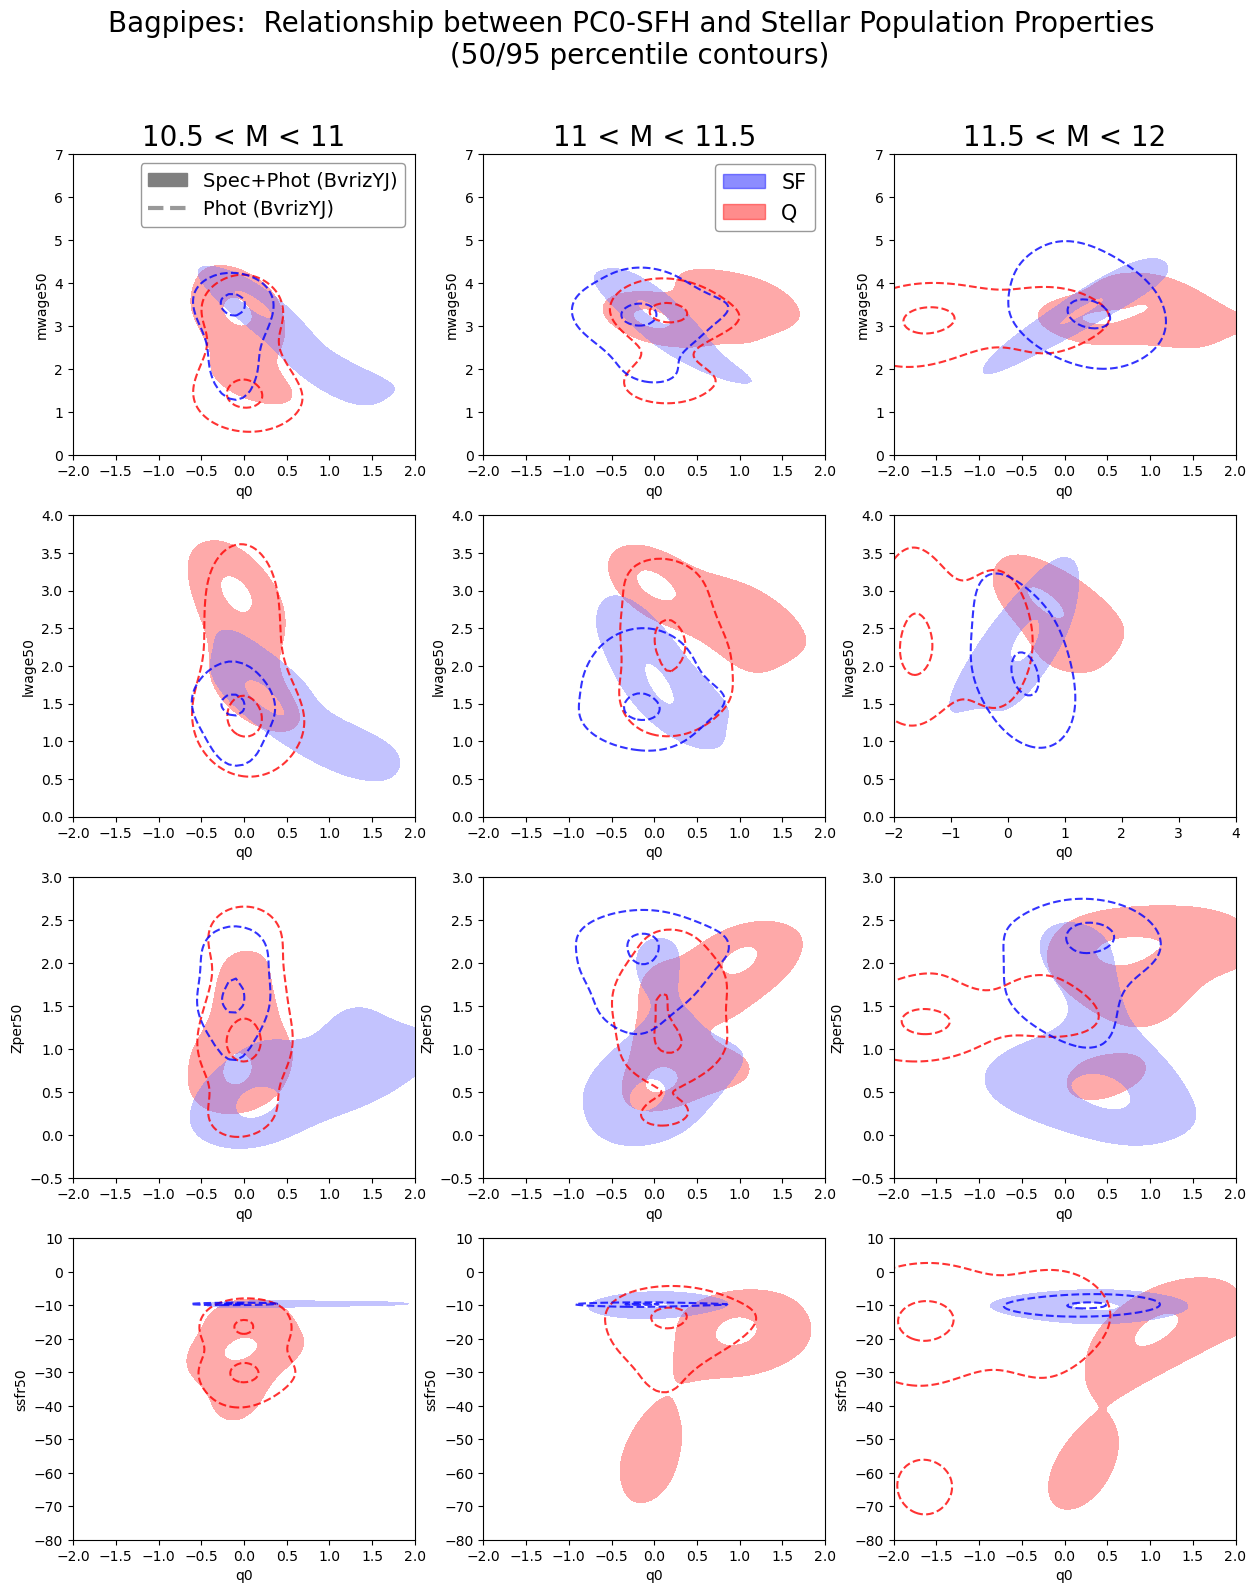

In [86]:
import seaborn as sns

fig, axes = plt.subplots(4,3,figsize=(15,18),sharex=False)
ax = axes.flatten()
levels = [0.5,.95]
colors=['blue','red']

q = 'q0'

qxp1 = (qq1[q])/np.std(qq1[q])
qx1 = (qq1s[q])/np.std(qq1s[q])
sfxp1 = (qs1[q])/np.std(qs1[q])
sfx1 = (qs1s[q])/np.std(qs1s[q])

qxp2 = (qq2[q])/np.std(qq2[q])
qx2 = (qq2s[q])/np.std(qq2s[q])
sfxp2 = (qs2[q])/np.std(qs2[q])
sfx2 = (qs2s[q])/np.std(qs2s[q])

qxp3 = (qq3[q])/np.std(qq3[q])
qx3 = (qq3s[q])/np.std(qq3s[q])
sfxp3 = (qs3[q])/np.std(qs3[q])
sfx3 = (qs3s[q])/np.std(qs3s[q])

f = 15    

ax[0].set_title('10.5 < M < 11',fontsize=20)
ax[1].set_title('11 < M < 11.5',fontsize=20)
ax[2].set_title('11.5 < M < 12',fontsize=20)

# Mass-weighted ages mwage50 ===========

ax[0].set_xlim(-2,2)
ax[0].set_ylim(0,7)

ax[1].set_xlim(-2,2)
ax[1].set_ylim(0,7)

ax[2].set_xlim(-2,2)
ax[2].set_ylim(0,7)

prop = 'mwage50'
alpha = 0.45
alphap = 0.8

sns.kdeplot(x=qxp1, y=qq1[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[0], alpha=alphap)
sns.kdeplot(x=qx1, y=qq1s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[0], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp1, y=qs1[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[0], alpha=alphap)
sns.kdeplot(x=sfx1, y=qs1s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[0], alpha=alpha,fill=True)

sns.kdeplot(x=qxp2, y=qq2[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[1], alpha=alphap)
sns.kdeplot(x=qx2, y=qq2s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[1], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp2, y=qs2[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[1], alpha=alphap)
sns.kdeplot(x=sfx2, y=qs2s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[1], alpha=alpha,fill=True)

sns.kdeplot(x=qxp3, y=qq3[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[2], alpha=alphap)
sns.kdeplot(x=qx3, y=qq3s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[2], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp3, y=qs3[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[2], alpha=alphap)
sns.kdeplot(x=sfx3, y=qs3s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[2], alpha=alpha,fill=True)


# Light-weighted ages lwage50 ===========

ax[3].set_xlim(-2,2)
ax[3].set_ylim(0,4)

ax[4].set_xlim(-2,2)
ax[4].set_ylim(0,4)

ax[5].set_xlim(-2,4)
ax[5].set_ylim(0,4)

prop = 'lwage50'

sns.kdeplot(x=qxp1, y=qq1[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[3], alpha=alphap)
sns.kdeplot(x=qx1, y=qq1s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[3], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp1, y=qs1[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[3], alpha=alphap)
sns.kdeplot(x=sfx1, y=qs1s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[3], alpha=alpha,fill=True)

sns.kdeplot(x=qxp2, y=qq2[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[4], alpha=alphap)
sns.kdeplot(x=qx2, y=qq2s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[4], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp2, y=qs2[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[4], alpha=alphap)
sns.kdeplot(x=sfx2, y=qs2s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[4], alpha=alpha,fill=True)

sns.kdeplot(x=qxp3, y=qq3[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[5], alpha=alphap)
sns.kdeplot(x=qx3, y=qq3s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[5], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp3, y=qs3[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[5], alpha=alphap)
sns.kdeplot(x=sfx3, y=qs3s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[5], alpha=alpha,fill=True)


# Stellar Metallicity Zper50 ===========

ax[6].set_xlim(-2,2)
ax[6].set_ylim(-0.5,3)

ax[7].set_xlim(-2,2)
ax[7].set_ylim(-0.5,3)

ax[8].set_xlim(-2,2)
ax[8].set_ylim(-0.5,3)

prop = 'Zper50'

sns.kdeplot(x=qxp1, y=qq1[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[6], alpha=alphap)
sns.kdeplot(x=qx1, y=qq1s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[6], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp1, y=qs1[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[6], alpha=alphap)
sns.kdeplot(x=sfx1, y=qs1s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[6], alpha=alpha,fill=True)

sns.kdeplot(x=qxp2, y=qq2[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[7], alpha=alphap)
sns.kdeplot(x=qx2, y=qq2s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[7], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp2, y=qs2[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[7], alpha=alphap)
sns.kdeplot(x=sfx2, y=qs2s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[7], alpha=alpha,fill=True)

sns.kdeplot(x=qxp3, y=qq3[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[8], alpha=alphap)
sns.kdeplot(x=qx3, y=qq3s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[8], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp3, y=qs3[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[8], alpha=alphap)
sns.kdeplot(x=sfx3, y=qs3s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[8], alpha=alpha,fill=True)


# specific star-formation rate ssfr50 ===========

ax[9].set_xlim(-2,2)
ax[9].set_ylim(-80,10)

ax[10].set_xlim(-2,2)
ax[10].set_ylim(-80,10)

ax[11].set_xlim(-2,2)
ax[11].set_ylim(-80,10)

prop = 'ssfr50'

sns.kdeplot(x=qxp1, y=qq1[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[9], alpha=alphap)
sns.kdeplot(x=qx1, y=qq1s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[9], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp1, y=qs1[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[9], alpha=alphap)
sns.kdeplot(x=sfx1, y=qs1s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[9], alpha=alpha,fill=True)

sns.kdeplot(x=qxp2, y=qq2[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[10], alpha=alphap)
sns.kdeplot(x=qx2, y=qq2s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[10], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp2, y=qs2[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[10], alpha=alphap)
sns.kdeplot(x=sfx2, y=qs2s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[10], alpha=alpha,fill=True)

sns.kdeplot(x=qxp3, y=qq3[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[11], alpha=alphap)
sns.kdeplot(x=qx3, y=qq3s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[11], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp3, y=qs3[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[11], alpha=alphap)
sns.kdeplot(x=sfx3, y=qs3s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[11], alpha=alpha,fill=True)


fig.suptitle('Bagpipes:  Relationship between PC0-SFH and Stellar Population Properties \n (50/95 percentile contours)',fontsize=20,y=0.96)

handles, labels = plt.gca().get_legend_handles_labels()
patch0 = mpatches.Patch(color='grey', label='Spec+Phot (BvrizYJ)')
line2 = Line2D([0], [0], label='Phot (BvrizYJ)', color='grey',linestyle='dashed',linewidth = 3,alpha=0.8)
handles.extend([patch0,line2])
leg = ax[0].legend(handles=handles,fontsize=14,loc='upper right',markerscale=1.3,frameon=True,edgecolor='grey')

handles, labels = plt.gca().get_legend_handles_labels()
patch1 = mpatches.Patch(color=colors[0], label='SF', alpha=alpha)
patch2 = mpatches.Patch(color=colors[1], label='Q' , alpha=alpha)
handles.extend([patch1,patch2])
leg = ax[1].legend(handles=handles,fontsize=15,loc='upper right',markerscale=1.3,frameon=True,edgecolor='grey')


# fig.savefig('/Users/yashakaushal/Documents/my_papers/paper2/plots/uglyplots/bp_q0_stelpops_photall.pdf',bbox_inches='tight')


### NOTE - 

1. Adding spectroscopic information in leading to expected correlation between ages (mass and light weighted both) and SFH PC0 coefficient q0 in Star-Forming galaxies (shaded blue) and to some extent in quiescent galaxies as well (shaded red). 
2. Contours of photometry only data (dotted red and dotted blue) are primary concentrated around q0 = 0 indicating weak dependance on SFH, except the most massive bin (11.5 < M < 12) where quiescent galaxies show opposite dependence on SFH (dotted red vs shaded red) 
3. Ages and Metallicites of most massive quiescent systems from photometric only data are not well recovered and require spectroscopic information. 

**Now repeating all above steps for other Bayesian SED fitting tool - PROSPECTOR**

## TOOL - 2 &ensp; Prospector 

In [95]:
# Mentioning path to SFHs
prosp_p_sfh_path = '/Users/yashakaushal/Documents/my_papers/paper2/data/prospector/p_bj/'
prosp_s_sfh_path = '/Users/yashakaushal/Documents/my_papers/paper2/data/prospector/spec_phot_bj/'

# Loading photometric catalog
prosp_p_cat = pd.read_csv('/Users/yashakaushal/Documents/my_papers/paper2/data/prospector/p_bj/params_outputs.csv',index_col=0)

# Loading spectro-photometric catalog
param_path = '/Users/yashakaushal/Documents/my_papers/paper2/data/prospector/spec_phot_bj/params_csv/'
param_pathlist = glob.glob(param_path + "*.csv") 
cols = list(pd.read_csv(param_path+'params_37933+19.csv',index_col=0).columns)
prosp_s_cat = pd.DataFrame(columns = cols)

for i,j in enumerate(param_pathlist):
    pt = pd.read_csv(j,index_col=0)
    prosp_s_cat.loc[i] = (pt.loc[0].to_list())
    
prosp_s_cat.rename(columns={'IDM':'idm'},inplace =True)
prosp_s_cat.head()

idm       z  logMsurv_16  logMsurv_50  logMsurv_84    logM_16  \
0  256362+27  0.7070    10.329046    10.374901    10.423770  10.531235   
1   70518+32  0.6999    10.001890    10.052042    10.088765  10.188911   
2   84766+15  0.8499    11.272121    11.280085    11.284108  11.500793   
3  190455+24  0.8927    11.396042    11.424452    11.449488  11.611438   
4   206894+1  0.9141    10.798200    10.837608    10.888511  10.998414   

     logM_50    logM_84   logZ_16   logZ_50  ...  sfr100Myr_err  sfr500Myr  \
0  10.577876  10.626543 -0.255447 -0.173752  ...   2.202374e+00   6.115108   
1  10.242200  10.282336 -0.144976 -0.085908  ...   8.881784e-16   4.317761   
2  11.503853  11.506495 -0.283896 -0.097983  ...   6.476612e-02   0.766464   
3  11.642254  11.667436  0.080869  0.095176  ...   2.503736e-04   0.750047   
4  11.038780  11.092386 -0.219000 -0.152945  ...   5.329071e-15  13.738456   

   sfr500Myr_err    sfr1Gyr  sfr1Gyr_err    sfr2Gyr  sfr2Gyr_err  log_lbol_16  \
0   1.705962e+00   4.910857     1.714958   4.125272     1.540199    10.865683   
1   4.319068e-03   4.209635     0.197976   3.762872     0.753788    10.819734   
2   5.348097e-01   0.441539     0.499012   0.271353     0.391929    11.238186   
3   3.732992e-03   0.743094     0.013729   1.025379     0.320534    11.375910   
4   5.329071e-15  13.734553     0.011721  13.014107     2.573577    11.394800   

   log_lbol_50  log_lbol_84  
0    10.934436    11.008521  
1    10.849234    10.876601  
2    11.287020    11.300754  
3    11.392441    11.413139  
4    11.433835    11.483777  

[5 rows x 48 columns]

In [94]:
prosp_p_cat.head()

IDM       z    logM_16    logM_50    logM_84   logZ_16   logZ_50  \
0  145306+23  0.6714  11.254260  11.272646  11.290142  0.123082  0.176894   
1   208797+2  0.6971  11.131633  11.193174  11.243546 -0.441845 -0.362494   
2  199990+10  0.9233  11.378894  11.463809  11.713669 -0.359291 -0.245690   
3   134358+1  0.9027  10.747705  10.847188  10.946175 -0.297988 -0.010836   
4   91497+18  0.8401  10.934749  11.022800  11.093787 -0.145196  0.093223   

    logZ_84  dust2_16  dust2_50  ...     bf_84    mwa_16    mwa_50    mwa_84  \
0  0.227875  0.241010  0.318857  ...  0.015148  6.024278  6.194306  6.336100   
1 -0.269031  2.146268  2.236076  ...  0.108231  3.125748  3.417504  3.779421   
2  0.235965  0.502277  1.493448  ...  0.749751  0.657575  0.970173  2.946055   
3  0.293577  0.214068  0.453660  ...  0.068640  2.390002  2.978037  3.555322   
4  0.364658  0.253842  0.422186  ...  0.010557  3.295697  3.815529  4.349815   

     lwa_16    lwa_50    lwa_84   lwar_16   lwar_50   lwar_84  
0  2.907554  3.408951  3.887231  4.435081  4.817499  5.223554  
1  1.361582  1.640084  1.950430  1.770150  2.039718  2.403063  
2  0.145973  0.196597  1.763438  0.355378  0.464724  2.120451  
3  1.751868  2.545836  3.173254  1.848837  2.578169  3.186887  
4  2.918666  3.416130  4.062130  2.943647  3.445705  4.106514  

[5 rows x 32 columns]

### Prospector - Photometry only

#### Saving MEDIAN SFH information in dataframes

In [96]:
idmlist = nscat['idm']

mmin = [10.5,11,11.5,10.5,11,11.5]
mmax = [11,11.5,12,11,11.5,12]
uvjsf = [0,0,0,1,1,1]
names = ['pdf1lb','pdf2lb','pdf3lb','pdf4lb','pdf5lb','pdf6lb']

for mmin,mmax,uvjsf,name in list(zip(mmin,mmax,uvjsf,names)):
    
    cut = (nscat.LOGM_MEDIAN>mmin) & (nscat.LOGM_MEDIAN<mmax) & (nscat.UVJ_SFQ==uvjsf)
    idmlist = np.array(nscat['idm'][cut])
    df = pd.DataFrame(columns=['sfh_' + str(i) for i in (idmlist.astype(str))])
    age_grid = np.linspace(0.01,8,2000)
    df['ages'] = age_grid

    
    for i in range(len(idmlist)):
        try:
            idm = idmlist[i]
            sfh = pd.read_csv(prosp_p_sfh_path+'sfh_csv/sfh_%s.csv'%idm)
            ages = np.array(sfh['lookbacktime'])
            sfh50 = sfh['sfh50']
            f1 = interp1d(ages,sfh50,kind='linear',fill_value=(0,0),bounds_error=False)  # interpolating on common age grid
            s1 = f1(age_grid)
            df.iloc[:,i] = s1
            
        except FileNotFoundError:
            pass

    df = df.dropna(axis=1)
    df.to_csv(prosp_p_sfh_path + 'dfs/' + name + '.csv')



In [98]:
# Example of saved dataframe (note ages are in the last column) 

pd.read_csv(prosp_p_sfh_path + 'dfs/' + 'pdf1lb.csv',index_col=0).head()

sfh_4121+16  sfh_4748+16  sfh_4792+16  sfh_6057+16  sfh_6311+16  \
0     1.162262     19.68173     2.470629     2.181790    46.914165   
1     1.169924     19.68173     2.470629     2.231036    46.914165   
2     1.181405     19.68173     2.470629     2.248345    46.914165   
3     1.193536     19.68173     2.470629     2.258355    46.914165   
4     1.213359     19.68173     2.470629     2.267590    46.914165   

   sfh_10224+16  sfh_11644+16  sfh_13315+16  sfh_13719+16  sfh_25361+14  ...  \
0      6.628911     70.880857    204.223496     86.139138      3.364173  ...   
1      6.651778     70.880857    204.223496     86.139138      3.364173  ...   
2      6.758260     70.875963    204.223496     86.139138      3.364173  ...   
3      6.881660     70.875963    204.223496     86.139138      3.364173  ...   
4      6.951636     70.875963    204.223496     86.139138      3.364173  ...   

   sfh_260092+13  sfh_260156+27  sfh_260156+31  sfh_260355+11  sfh_260481+27  \
0       7.544647      25.816173        8.45694       5.898794       5.665689   
1       7.544647      25.816173        8.45694       8.335329       5.665689   
2       7.544647      25.816173        8.45694      16.300846       5.665689   
3       7.552082      25.816173        8.45694      40.329292       5.665689   
4       7.565989      25.816173        8.45694     451.188638       5.665689   

   sfh_261099+27  sfh_261136+13  sfh_261337+31  sfh_261890+27      ages  
0       3.876284       4.354410       2.061517       4.015137  0.010000  
1       3.876284       4.528184       2.061517       4.015137  0.013997  
2       3.876284       4.568360       2.061517       4.015137  0.017994  
3       3.876284       4.578865       2.061517       4.015137  0.021991  
4       3.876284       4.585591       2.061517       4.020122  0.025988  

[5 rows x 696 columns]

### Prospector - Spectro-photometric data

#### Saving MEDIAN SFH information in dataframes

In [100]:
idmlist = nscat['idm']

mmin = [10.5,11,11.5,10.5,11,11.5]
mmax = [11,11.5,12,11,11.5,12]
uvjsf = [0,0,0,1,1,1]
names = ['df1lb','df2lb','df3lb','df4lb','df5lb','df6lb']

for mmin,mmax,uvjsf,name in list(zip(mmin,mmax,uvjsf,names)):
    
    cut = (nscat.LOGM_MEDIAN>mmin) & (nscat.LOGM_MEDIAN<mmax) & (nscat.UVJ_SFQ==uvjsf)
    idmlist = np.array(nscat['idm'][cut])
    df = pd.DataFrame(columns=['sfh_' + i for i in (idmlist.astype(str))])
    age_grid = np.linspace(0.01,8,2000)
    df['ages'] = age_grid
    
    for i in range(len(idmlist)):
        try:
            idm = idmlist[i]
            sfh = pd.read_csv(prosp_s_sfh_path+'sfh_csv/sfh_%s.csv'%idm)
            ages = np.array(sfh['lookbacktime'])
            sfh50 = sfh['sfh50']
            f1 = interp1d(ages,sfh50,kind='linear',fill_value=(0,0),bounds_error=False)  # interpolating on common age grid
            s1 = f1(age_grid)
            df.iloc[:,i] = s1
            
        except FileNotFoundError:
            pass
        
    df = df.dropna(axis=1)
    df.to_csv(prosp_s_sfh_path + 'dfs/' + name + '.csv')



In [101]:
# Example of saved dataframe (note ages are in the last column) 

pd.read_csv(prosp_s_sfh_path + 'dfs/' + 'df1lb.csv',index_col=0).head()

sfh_4121+16  sfh_4748+16  sfh_4792+16  sfh_6057+16  sfh_6311+16  \
0      1.84698      6.15495     3.702111     7.627284     8.057896   
1      1.84698      6.15495     3.702111     7.627284     8.057896   
2      1.84698      6.15495     3.702111     7.627284     8.057896   
3      1.84698      6.15495     3.702111     7.625855     8.057896   
4      1.84698      6.15495     3.702111     7.623291     8.057896   

   sfh_10224+16  sfh_11644+16  sfh_13315+16  sfh_13719+16  sfh_25361+14  ...  \
0     14.940838     21.551713     16.403943     28.424567       5.36097  ...   
1     14.940838     21.550500     16.403943     28.424567       5.36097  ...   
2     14.940838     21.550497     16.403943     28.424567       5.36097  ...   
3     14.940838     21.485429     16.403943     28.424567       5.36097  ...   
4     14.940838     21.455821     16.403943     28.424567       5.36097  ...   

   sfh_258814+31  sfh_259554+13  sfh_260092+13  sfh_260156+27  sfh_260156+31  \
0      27.303164       4.015820      32.288389      14.174741      19.974569   
1      27.303164       4.018766      32.288389      14.174741      19.974569   
2      27.303164       4.021485      32.288389      14.174741      19.974569   
3      27.303164       4.021485      32.288389      14.174741      19.974569   
4      27.303164       4.023707      32.288389      14.174741      19.974569   

   sfh_260355+11  sfh_261136+13  sfh_261337+31  sfh_261890+27      ages  
0      54.266349       5.637442       6.930705      17.350398  0.010000  
1      54.266349       5.637442       6.930705      17.350398  0.013997  
2      54.266349       5.637442       6.930705      17.350398  0.017994  
3      54.266349       5.637442       6.930705      17.350398  0.021991  
4      54.266349       5.637442       6.930705      17.350398  0.025988  

[5 rows x 764 columns]

#### Reading all dataframes here 

In [139]:
# Prospector 

df1lb = pd.read_csv(prosp_p_sfh_path + 'dfs/pdf1lb.csv')
df2lb = pd.read_csv(prosp_p_sfh_path + 'dfs/pdf2lb.csv')
df3lb = pd.read_csv(prosp_p_sfh_path + 'dfs/pdf3lb.csv')
df4lb = pd.read_csv(prosp_p_sfh_path + 'dfs/pdf4lb.csv')
df5lb = pd.read_csv(prosp_p_sfh_path + 'dfs/pdf5lb.csv')
df6lb = pd.read_csv(prosp_p_sfh_path + 'dfs/pdf6lb.csv')


df1lbs = pd.read_csv(prosp_s_sfh_path + 'dfs/df1lb.csv')
df2lbs = pd.read_csv(prosp_s_sfh_path + 'dfs/df2lb.csv')
df3lbs = pd.read_csv(prosp_s_sfh_path + 'dfs/df3lb.csv')
df4lbs = pd.read_csv(prosp_s_sfh_path + 'dfs/df4lb.csv')
df5lbs = pd.read_csv(prosp_s_sfh_path + 'dfs/df5lb.csv')
df6lbs = pd.read_csv(prosp_s_sfh_path + 'dfs/df6lb.csv')


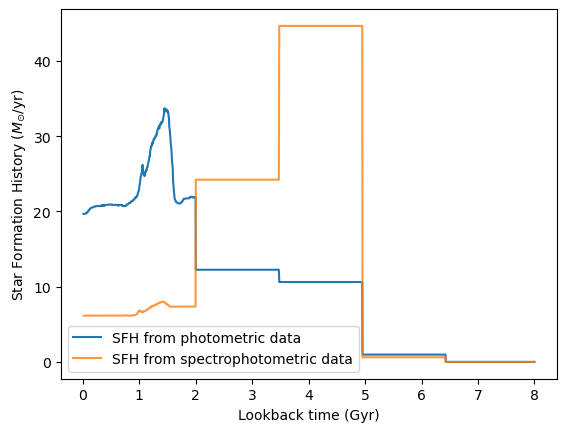

In [140]:
# Example plot to check SFHs stored in the dataframes

age_grid = df1lb.ages
plt.plot(age_grid,df1lb.iloc[:,2],label='SFH from photometric data') # SFH from photometric data
plt.plot(age_grid,df1lbs.iloc[:,2],label='SFH from spectrophotometric data',alpha=0.8) # SFH from spectro-photometric data
plt.xlabel('Lookback time (Gyr)') 
plt.ylabel('Star Formation History ($M_{\odot}$/yr)')
plt.legend()

Text(0.5, 0.98, 'All Star-Formation Histories from two models in Stellar Mass bins \n for Star-Forming Galaxies in PROSPECTOR')

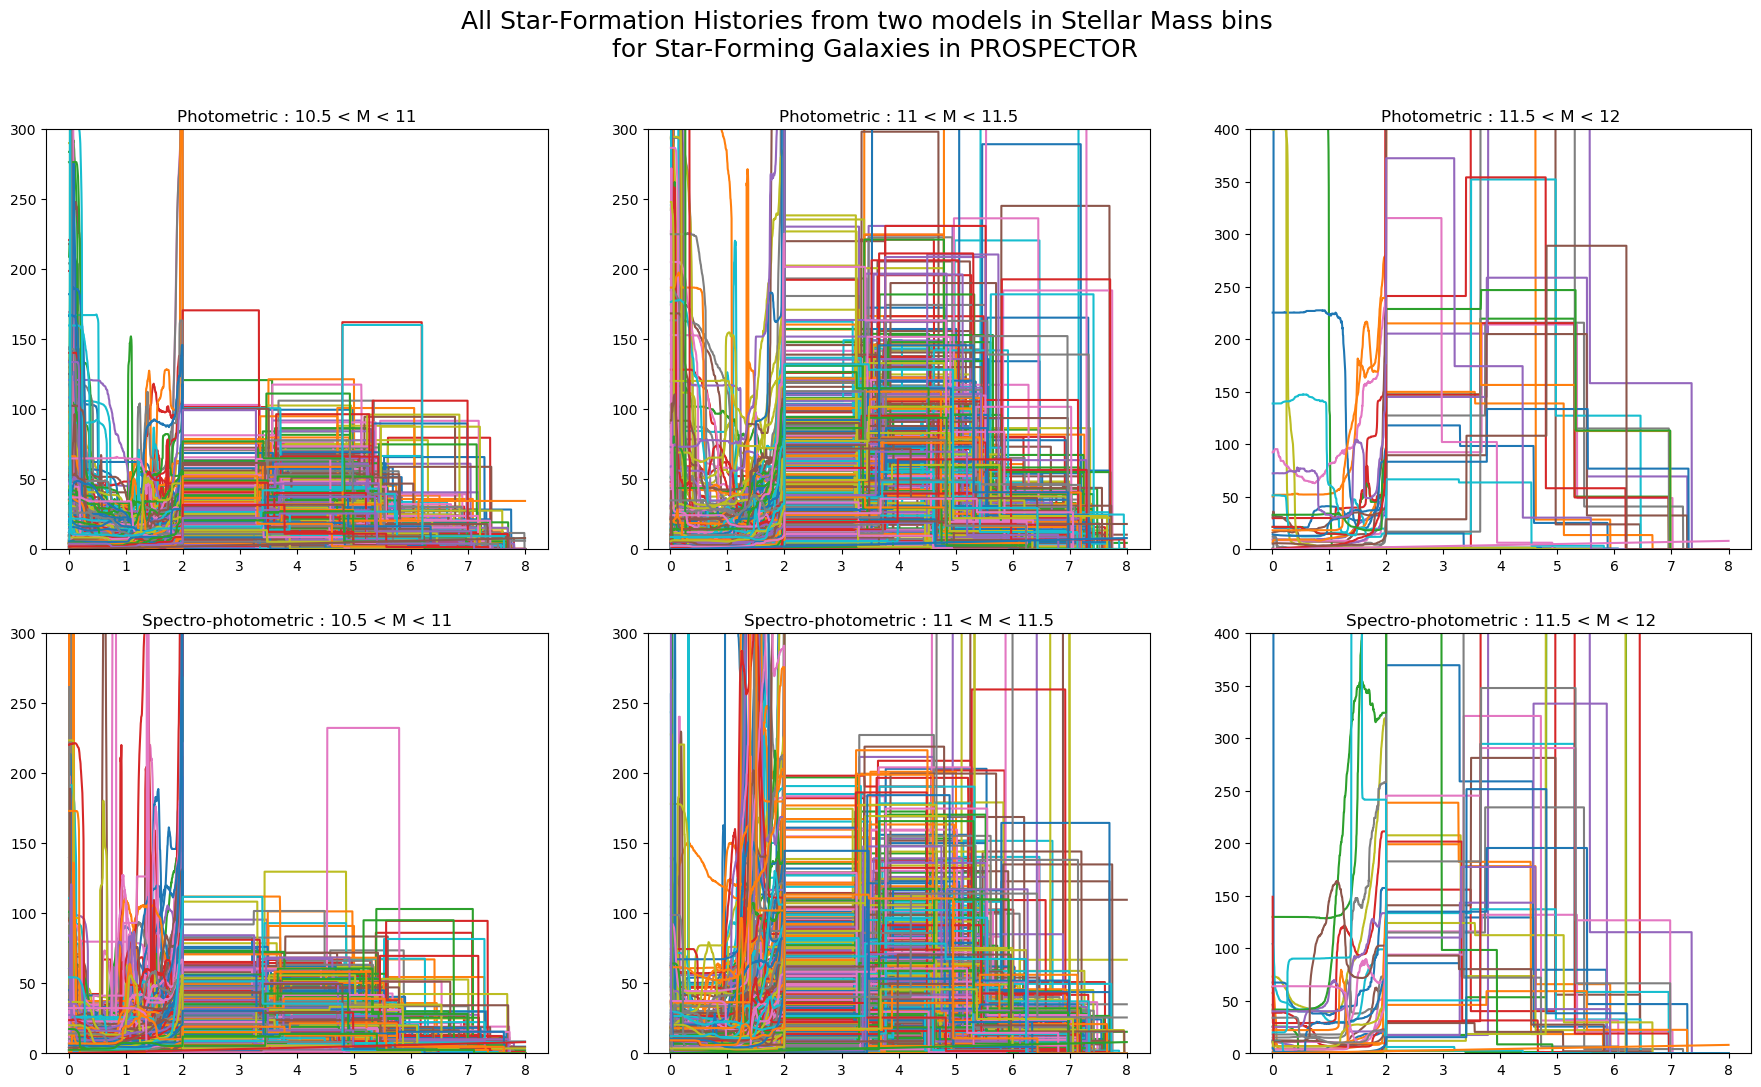

In [111]:
# Plotting all SFHs of Star-forming galaxies in Prospector

fig, axes = plt.subplots(2,3,figsize=(22,12),sharex=False)
ax = axes.flatten()

# SFH from photometric data

for i in range(1,df1lb.shape[1]):
    ax[0].plot(age_grid,df1lb.iloc[:,i])

for i in range(1,df2lb.shape[1]):
    ax[1].plot(age_grid,df2lb.iloc[:,i])

for i in range(1,df3lb.shape[1]):
    ax[2].plot(age_grid,df3lb.iloc[:,i])
    
# SFH from spectro-photometric data
 
for i in range(1,df1lbs.shape[1]):
    ax[3].plot(age_grid,df1lbs.iloc[:,i])

for i in range(1,df2lbs.shape[1]):
    ax[4].plot(age_grid,df2lbs.iloc[:,i])

for i in range(1,df3lbs.shape[1]):
    ax[5].plot(age_grid,df3lbs.iloc[:,i])

ax[0].set_title('Photometric : 10.5 < M < 11') 
ax[1].set_title('Photometric : 11 < M < 11.5') 
ax[2].set_title('Photometric : 11.5 < M < 12') 

ax[3].set_title('Spectro-photometric : 10.5 < M < 11') 
ax[4].set_title('Spectro-photometric : 11 < M < 11.5') 
ax[5].set_title('Spectro-photometric : 11.5 < M < 12') 

ax[0].set_ylim(0,300)
ax[3].set_ylim(0,300)

ax[1].set_ylim(0,300)
ax[4].set_ylim(0,300)

ax[2].set_ylim(0,400)
ax[5].set_ylim(0,400)


# fig.subplots_adjust(hspace=0.2,wspace=0.3)

fig.suptitle('All Star-Formation Histories from two models in Stellar Mass bins \n for Star-Forming Galaxies in PROSPECTOR',y=0.98,fontsize=18)

Text(0.5, 0.98, 'All Star-Formation Histories from two models in Stellar Mass bins \n for Quiescent Galaxies in Prospector')

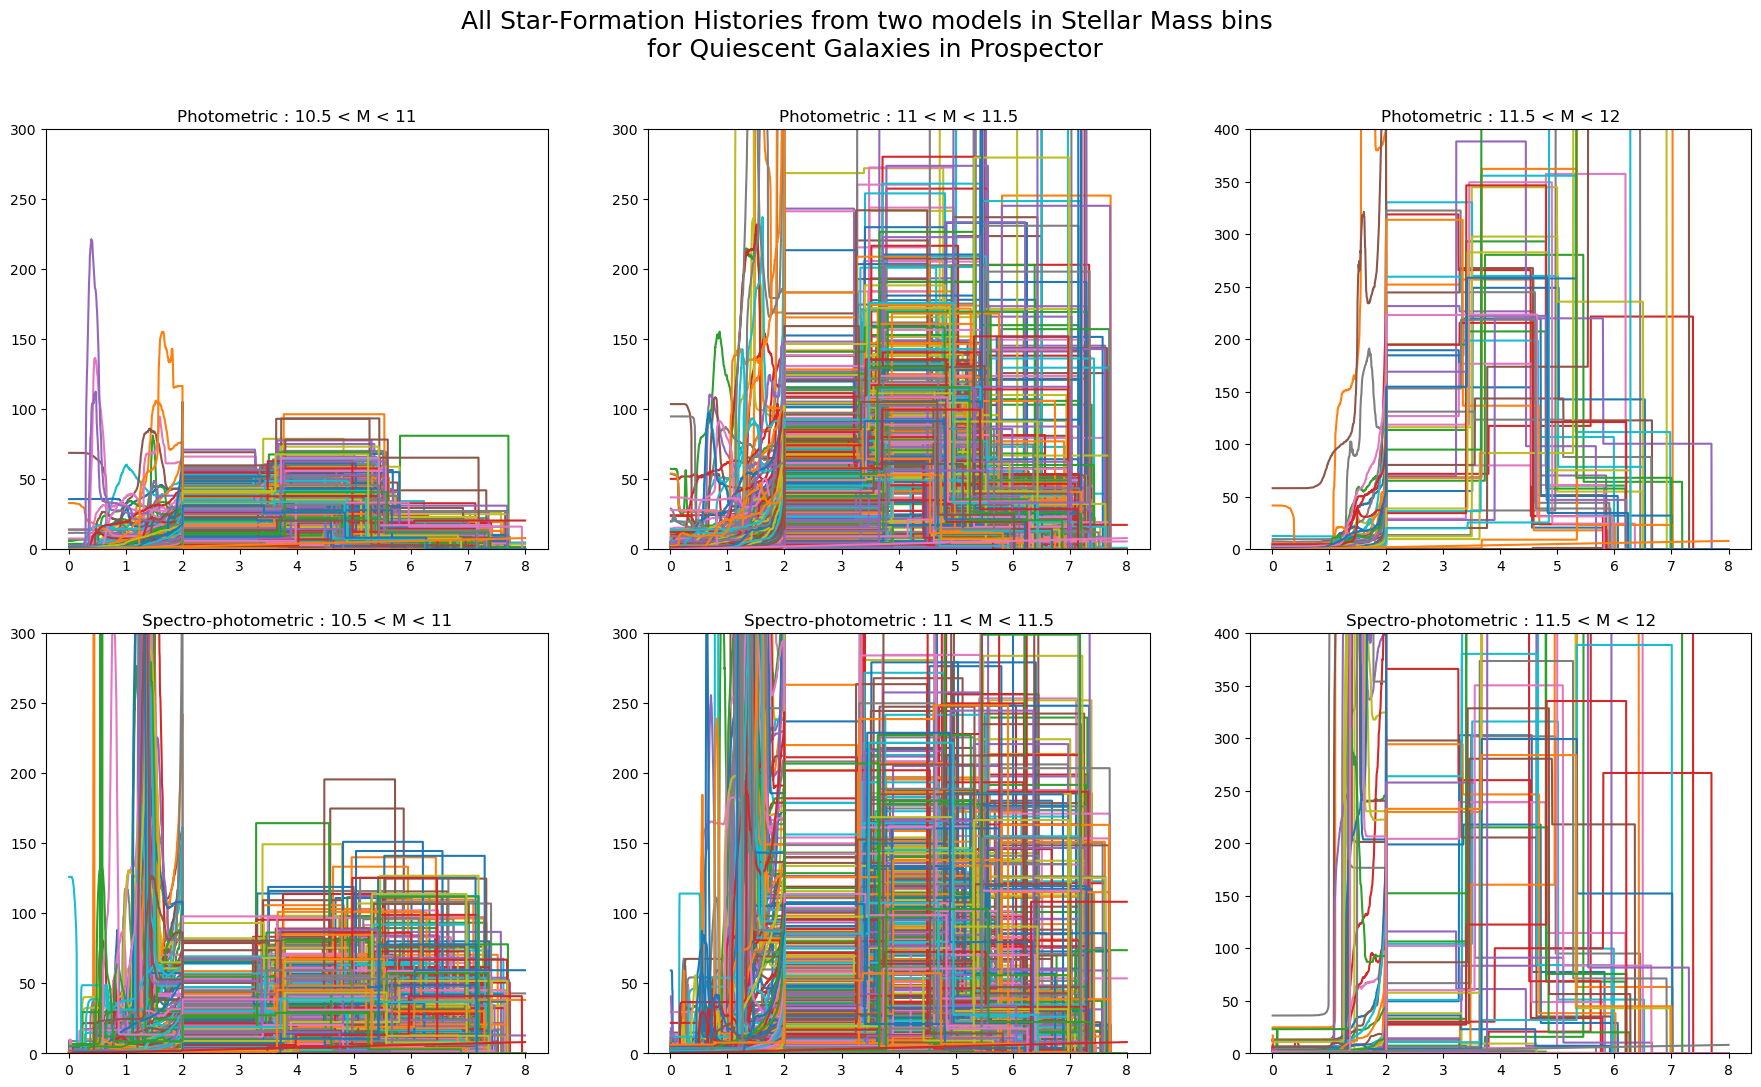

In [112]:
# Plotting all SFHs of Quiescent galaxies in Prospector 

fig, axes = plt.subplots(2,3,figsize=(22,12),sharex=False)
ax = axes.flatten()

# SFH from photometric data

for i in range(1,df4lb.shape[1]):
    ax[0].plot(age_grid,df4lb.iloc[:,i])

for i in range(1,df5lb.shape[1]):
    ax[1].plot(age_grid,df5lb.iloc[:,i])

for i in range(1,df6lb.shape[1]):
    ax[2].plot(age_grid,df6lb.iloc[:,i])
    
# SFH from spectro-photometric data
 
for i in range(1,df4lbs.shape[1]):
    ax[3].plot(age_grid,df4lbs.iloc[:,i])

for i in range(1,df5lbs.shape[1]):
    ax[4].plot(age_grid,df5lbs.iloc[:,i])

for i in range(1,df6lbs.shape[1]):
    ax[5].plot(age_grid,df6lbs.iloc[:,i])

ax[0].set_title('Photometric : 10.5 < M < 11') 
ax[1].set_title('Photometric : 11 < M < 11.5') 
ax[2].set_title('Photometric : 11.5 < M < 12') 

ax[3].set_title('Spectro-photometric : 10.5 < M < 11') 
ax[4].set_title('Spectro-photometric : 11 < M < 11.5') 
ax[5].set_title('Spectro-photometric : 11.5 < M < 12') 

ax[0].set_ylim(0,300)
ax[3].set_ylim(0,300)

ax[1].set_ylim(0,300)
ax[4].set_ylim(0,300)

ax[2].set_ylim(0,400)
ax[5].set_ylim(0,400)


# fig.subplots_adjust(hspace=0.2,wspace=0.3)

fig.suptitle('All Star-Formation Histories from two models in Stellar Mass bins \n for Quiescent Galaxies in Prospector',y=0.98,fontsize=18)

In [141]:
# Photometry only data

ncomp = 3

dft1 = pd.DataFrame(data=df1lb.iloc[:,1:-1])
dft1.dropna(axis=1,inplace = True)
pca1 = PCA(n_components=ncomp)
pca1.fit(dft1.T)
(pca1.components_)[0]

dft2 = pd.DataFrame(data=df2lb.iloc[:,1:-1])
dft2.dropna(axis=1,inplace = True)
pca2 = PCA(n_components=ncomp)
pca2.fit(dft2.T)
(pca2.components_)[0]

dft3 = pd.DataFrame(data=df3lb.iloc[:,1:-1])
dft3.dropna(axis=1,inplace = True)
pca3 = PCA(n_components=ncomp)
pca3.fit(dft3.T)
(pca3.components_)[0]

dft4 = pd.DataFrame(data=df4lb.iloc[:,1:-1])
dft4.dropna(axis=1,inplace = True)
pca4 = PCA(n_components=ncomp)
pca4.fit(dft4.T)
(pca4.components_)[0]

dft5 = pd.DataFrame(data=df5lb.iloc[:,1:-1])
dft5.dropna(axis=1,inplace = True)
pca5 = PCA(n_components=ncomp)
pca5.fit(dft5.T)
(pca5.components_)[0]

dft6 = pd.DataFrame(data=df6lb.iloc[:,1:-1])
dft6.dropna(axis=1,inplace = True)
pca6 = PCA(n_components=ncomp)
pca6.fit(dft6.T)
(pca6.components_)[0]

(pca1.components_)[0]

array([-0.03329829, -0.03316895, -0.0318814 , ..., -0.00011357,
       -0.00011357, -0.00011357])

In [132]:
# Saving PCA coefficient values (q0,q1,q3) in dataframes

# fitting y = m1x1 + m2x2 + m3x3 + <sfh>
def func(x, m1, m2, m3):
    return (m1*x[0] + m2*x[1] + m3*x[2] + avg)

cols = ['q0','q1','q2']
dfs = [dft1,dft2,dft3,dft4,dft5,dft6]
pcas = [pca1,pca2,pca3,pca4,pca5,pca6]
qdfid = ['sf1','sf2','sf3','q1','q2','q3']
mmin = [10.5,11,11.5,10.5,11,11.5]
mmax = [11,11.5,12,11,11.5,12]
uvj = [0,0,0,1,1,1]

uvjsf=[]
for i in prosp_p_cat.IDM.to_list():
    uvjsf.append(nscat['UVJ_SFQ'][nscat.idm==i].iloc[0])

prosp_p_cat['uvjsf'] = uvjsf

for df,pca,qid,mmin,mmax,uvj in list(zip(dfs,pcas,qdfid,mmin,mmax,uvj)):

    cut = (prosp_p_cat.logM_50>mmin) & (prosp_p_cat.logM_50<mmax) & (prosp_p_cat.uvjsf==uvjsf)
    idmlist = np.array(prosp_p_cat['IDM'][cut])
    df = df.iloc[:,:-1]
    # same for each dataframe
    x1 = pca.components_[0]
    x2 = pca.components_[1]
    x3 = pca.components_[2]
    x = [x1,x2,x3]
    avg = np.mean(df,axis=1)/df.shape[1]
    ids = [col.split('_')[1] for col in df.columns]  # from column names
    qvals = pd.DataFrame(columns = cols,index=ids)

    for i,j in enumerate(ids):
        y = list(df.iloc[:,i])
        idm = j
        popt, pcov = curve_fit(func, x, y)
        qvals.iloc[i,:] = [popt[0],popt[1],popt[2]]

    qvals['IDM'] = qvals.index
    qvals = pd.merge(qvals,prosp_p_cat,on='IDM')
    qvals.to_csv('/Users/yashakaushal/Documents/my_papers/paper2/data/prospector/p_bj/PCA_bj/q_values_merged/%s.csv'%qid)


In [142]:
# Spectro-photometric data

ncomp = 3

dft1s = pd.DataFrame(data=df1lbs.iloc[:,1:-1])
dft1s.dropna(axis=1,inplace = True)
pca1s = PCA(n_components=ncomp)
pca1s.fit(dft1s.T)
(pca1s.components_)[0]

dft2s = pd.DataFrame(data=df2lbs.iloc[:,1:-1])
dft2s.dropna(axis=1,inplace = True)
pca2s = PCA(n_components=ncomp)
pca2s.fit(dft2s.T)
(pca2s.components_)[0]

dft3s = pd.DataFrame(data=df3lbs.iloc[:,1:-1])
dft3s.dropna(axis=1,inplace = True)
pca3s = PCA(n_components=ncomp)
pca3s.fit(dft3s.T)
(pca3s.components_)[0]

dft4s = pd.DataFrame(data=df4lbs.iloc[:,1:-1])
dft4s.dropna(axis=1,inplace = True)
pca4s = PCA(n_components=ncomp)
pca4s.fit(dft4s.T)
(pca4s.components_)[0]

dft5s = pd.DataFrame(data=df5lbs.iloc[:,1:-1])
dft5s.dropna(axis=1,inplace = True)
pca5s = PCA(n_components=ncomp)
pca5s.fit(dft5s.T)
(pca5s.components_)[0]

dft6s = pd.DataFrame(data=df6lbs.iloc[:,1:-1])
dft6s.dropna(axis=1,inplace = True)
pca6s = PCA(n_components=ncomp)
pca6s.fit(dft6s.T)
(pca6s.components_)[0]


array([ 0.00067538,  0.00070628,  0.00076939, ..., -0.        ,
       -0.        , -0.        ])

In [133]:
# Saving q0s, fitting y = m1x1 + m2x2 + m3x3 + <sfh>

# fitting y = m1x1 + m2x2 + m3x3 + <sfh>
def func(x, m1, m2, m3):
    return (m1*x[0] + m2*x[1] + m3*x[2] + avg)

cols = ['q0','q1','q2']
dfs = [dft1s,dft2s,dft3s,dft4s,dft5s,dft6s]
pcas = [pca1s,pca2s,pca3s,pca4s,pca5s,pca6s]
qdfid = ['sf1s','sf2s','sf3s','q1s','q2s','q3s']
mmin = [10.5,11,11.5,10.5,11,11.5]
mmax = [11,11.5,12,11,11.5,12]
uvj = [0,0,0,1,1,1]

uvjsf=[]
for i in prosp_s_cat.idm.to_list():
    uvjsf.append(nscat['UVJ_SFQ'][nscat.idm==i].iloc[0])

prosp_s_cat['uvjsf'] = uvjsf

for df,pca,qid,mmin,mmax,uvj in list(zip(dfs,pcas,qdfid,mmin,mmax,uvj)):

    cut = (prosp_s_cat.logM_50>mmin) & (prosp_s_cat.logM_50<mmax) & (prosp_s_cat.uvjsf==uvjsf)
    idmlist = np.array(prosp_s_cat['idm'][cut])
    df = df.iloc[:,:-1]
    # same for each dataframe
    x1 = pca.components_[0]
    x2 = pca.components_[1]
    x3 = pca.components_[2]
    x = [x1,x2,x3]
    avg = np.mean(df,axis=1)/df.shape[1]
    ids = [col.split('_')[1] for col in df.columns]  # from column names
    qvals = pd.DataFrame(columns = cols,index=ids)

    for i,j in enumerate(ids):
        y = list(df.iloc[:,i])
        idm = j
        popt, pcov = curve_fit(func, x, y)
        qvals.iloc[i,:] = [popt[0],popt[1],popt[2]]

    qvals['idm'] = qvals.index
    qvals = pd.merge(qvals,prosp_s_cat,on='idm')
    qvals.to_csv('/Users/yashakaushal/Documents/my_papers/paper2/data/prospector/spec_phot_bj/PCA_bj/q_values_merged/%s.csv'%qid)


### Plotting the principle components of SFH recovered from (1) Photometric data (2) Spectrophotometric data in one figure 

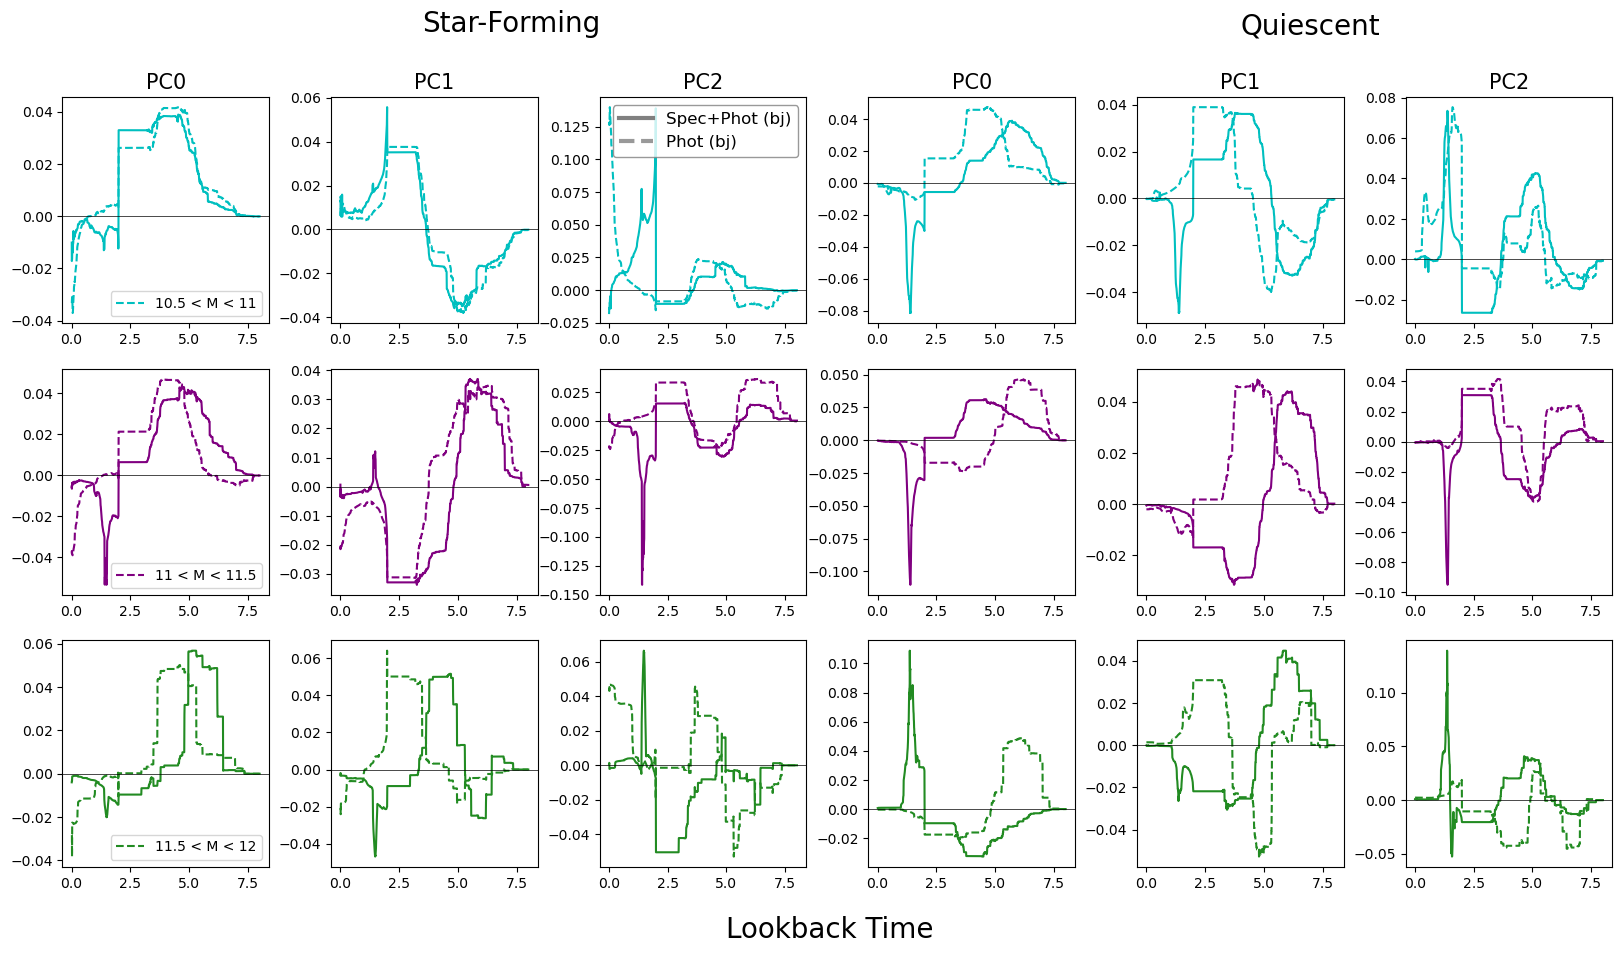

In [153]:
fig, axes = plt.subplots(3,6,figsize=(20,10),sharex=False)
ax = axes.flatten()

lsp = '--'
lss = '-'
alpha=1
colors=['c','purple','forestgreen']

# SF ======

ax[0].plot(age_grid,(pca1.components_)[0],label='10.5 < M < 11',linestyle=lsp,color=colors[0])
ax[1].plot(age_grid,(pca1.components_)[1],linestyle=lsp,color=colors[0])
ax[2].plot(age_grid,(pca1.components_)[2],linestyle=lsp,color=colors[0])

ax[6].plot(age_grid,(pca2.components_)[0],label='11 < M < 11.5',linestyle=lsp,color=colors[1])
ax[7].plot(age_grid,(pca2.components_)[1],linestyle=lsp,color=colors[1])
ax[8].plot(age_grid,(pca2.components_)[2],linestyle=lsp,color=colors[1])

ax[12].plot(age_grid,(pca3.components_)[0],label='11.5 < M < 12',linestyle=lsp,color=colors[2])
ax[13].plot(age_grid,(pca3.components_)[1],linestyle=lsp,color=colors[2])
ax[14].plot(age_grid,-1*(pca3.components_)[2],linestyle=lsp,color=colors[2])

ax[0].plot(age_grid,(pca1s.components_)[0],linestyle=lss,color=colors[0])
ax[1].plot(age_grid,-1*(pca1s.components_)[1],linestyle=lss,color=colors[0])
ax[2].plot(age_grid,(pca1s.components_)[2],linestyle=lss,color=colors[0])

ax[6].plot(age_grid,(pca2s.components_)[0],linestyle=lss,color=colors[1],alpha=alpha)
ax[7].plot(age_grid,(pca2s.components_)[1],linestyle=lss,color=colors[1],alpha=alpha)
ax[8].plot(age_grid,-1*(pca2s.components_)[2],linestyle=lss,color=colors[1],alpha=alpha)

ax[12].plot(age_grid,(pca3s.components_)[0],linestyle=lss,color=colors[2],alpha=alpha)
ax[13].plot(age_grid,(pca3s.components_)[1],linestyle=lss,color=colors[2],alpha=alpha)
ax[14].plot(age_grid,(pca3s.components_)[2],linestyle=lss,color=colors[2],alpha=alpha)


# Q =============
ax[3].plot(age_grid,(pca4.components_)[0],label='10.5 < M < 11',linestyle=lsp,color=colors[0])
ax[4].plot(age_grid,(pca4.components_)[1],linestyle=lsp,color=colors[0])
ax[5].plot(age_grid,(pca4.components_)[2],linestyle=lsp,color=colors[0])

ax[9].plot(age_grid,(pca5.components_)[0],label='11 < M < 11.5',linestyle=lsp,color=colors[1])
ax[10].plot(age_grid,(pca5.components_)[1],linestyle=lsp,color=colors[1])
ax[11].plot(age_grid,(pca5.components_)[2],linestyle=lsp,color=colors[1])

ax[15].plot(age_grid,(pca6.components_)[0],label='11.5 < M < 12',linestyle=lsp,color=colors[2])
ax[16].plot(age_grid,(pca6.components_)[1],linestyle=lsp,color=colors[2])
ax[17].plot(age_grid,(pca6.components_)[2],linestyle=lsp,color=colors[2])

ax[3].plot(age_grid,-1*(pca4s.components_)[0],linestyle=lss,color=colors[0])
ax[4].plot(age_grid,-1*(pca4s.components_)[1],linestyle=lss,color=colors[0])
ax[5].plot(age_grid,(pca4s.components_)[2],linestyle=lss,color=colors[0])

ax[9].plot(age_grid,-1*(pca5s.components_)[0],linestyle=lss,color=colors[1],alpha=alpha)
ax[10].plot(age_grid,(pca5s.components_)[1],linestyle=lss,color=colors[1],alpha=alpha)
ax[11].plot(age_grid,(pca5s.components_)[2],linestyle=lss,color=colors[1],alpha=alpha)

ax[15].plot(age_grid,(pca6s.components_)[0],linestyle=lss,color=colors[2],alpha=alpha)
ax[16].plot(age_grid,(pca6s.components_)[1],linestyle=lss,color=colors[2],alpha=alpha)
ax[17].plot(age_grid,(pca6s.components_)[2],linestyle=lss,color=colors[2],alpha=alpha)


for i in (0,6,12):
    ax[i].legend(fontsize=10)
    
for i in range(0,18):
    ax[i].axhline(0,ls='-',color='k',lw=0.5)
    
f = 15    
ax[0].set_title('PC0',fontsize=f)
ax[1].set_title('PC1',fontsize=f)
ax[2].set_title('PC2',fontsize=f)

ax[3].set_title('PC0',fontsize=f)
ax[4].set_title('PC1',fontsize=f)
ax[5].set_title('PC2',fontsize=f)

ax[1].text(3.5,0.09,'Star-Forming',fontsize=f+5)
ax[4].text(4,0.07,'Quiescent',fontsize=f+5)
ax[14].text(5,-0.1,'Lookback Time',fontsize=f+5)

# ax[1].text(3.5,0.12,'Star-Forming',fontsize=f+5)
# ax[4].text(4,0.20,'Quiescent',fontsize=f+5)

fig.subplots_adjust(hspace=0.2,wspace=0.3)

handles, labels = plt.gca().get_legend_handles_labels()

line1 = Line2D([0], [0], label='Spec+Phot (bj)', color='grey',linestyle='-',marker='',linewidth = 3,markersize=10)
line2 = Line2D([0], [0], label='Phot (bj)', color='grey',linestyle='dashed',linewidth = 3,alpha=0.8)
patch1 = mpatches.Patch(color=colors[0], label='10.5 < M < 11')
patch2 = mpatches.Patch(color=colors[1], label='11 < M < 11.5')
patch3 = mpatches.Patch(color=colors[2], label='11.5 < M < 12')

handles.extend([line1,line2])

leg = ax[2].legend(handles=handles,fontsize=12,loc='upper right',markerscale=1.3,frameon=True,edgecolor='grey')

# fig.savefig('/Users/yashakaushal/Documents/my_papers/paper2/plots/uglyplots/p_pca_comps.pdf',bbox_inches='tight')


### NOTE - 

1. We know that PC0 contains the most information of the SFH variance and PC1-PC2 represent information in higher modes. 
2. Y-axis represents the direction of maximum information variance with respect to the mean SFH of the population. 
3. Adding spectra definitely leads to better recovery of finer variations / higher moments of SFHs in the population, which are missed by photometric data.  
4. Most massive galaxies (11.5 < M < 12) show the largest difference in Principal Components from photometric data and spectrophotometric data. 
5. Early variablility of SFH is captured similarly for both methods in star-forming galaxies than quiescent galaxies, partly owing to their young stellar populations. 



### Plotting correlation of galaxy properties (like age, dust, metallicity) on SFH derived from the two data types

In [156]:
# Prospector 

lsp = '--'
lss = '-'
alpha=1
colors=['c','purple','forestgreen']

prosp_p_path = '/Users/yashakaushal/Documents/my_papers/paper2/data/prospector/p_bj/PCA_bj/q_values_merged/'
prosp_s_path = '/Users/yashakaushal/Documents/my_papers/paper2/data/prospector/spec_phot_bj/PCA_bj/q_values_merged/'

qq1 = pd.read_csv(prosp_p_path + 'q1.csv') # quiescent - phot only 
qq2 = pd.read_csv(prosp_p_path + 'q2.csv')
qq3 = pd.read_csv(prosp_p_path + 'q3.csv')

qq1s = pd.read_csv(prosp_s_path + 'q1s.csv') # quiescent - with spectra
qq2s = pd.read_csv(prosp_s_path + 'q2s.csv')
qq3s = pd.read_csv(prosp_s_path + 'q3s.csv')

qs1 = pd.read_csv(prosp_p_path + 'sf1.csv')  # star-forming - phot only 
qs2 = pd.read_csv(prosp_p_path + 'sf2.csv')
qs3 = pd.read_csv(prosp_p_path + 'sf3.csv')

qs1s = pd.read_csv(prosp_s_path + 'sf1s.csv')  # star-forming - with spectra
qs2s = pd.read_csv(prosp_s_path + 'sf2s.csv')
qs3s = pd.read_csv(prosp_s_path + 'sf3s.csv')


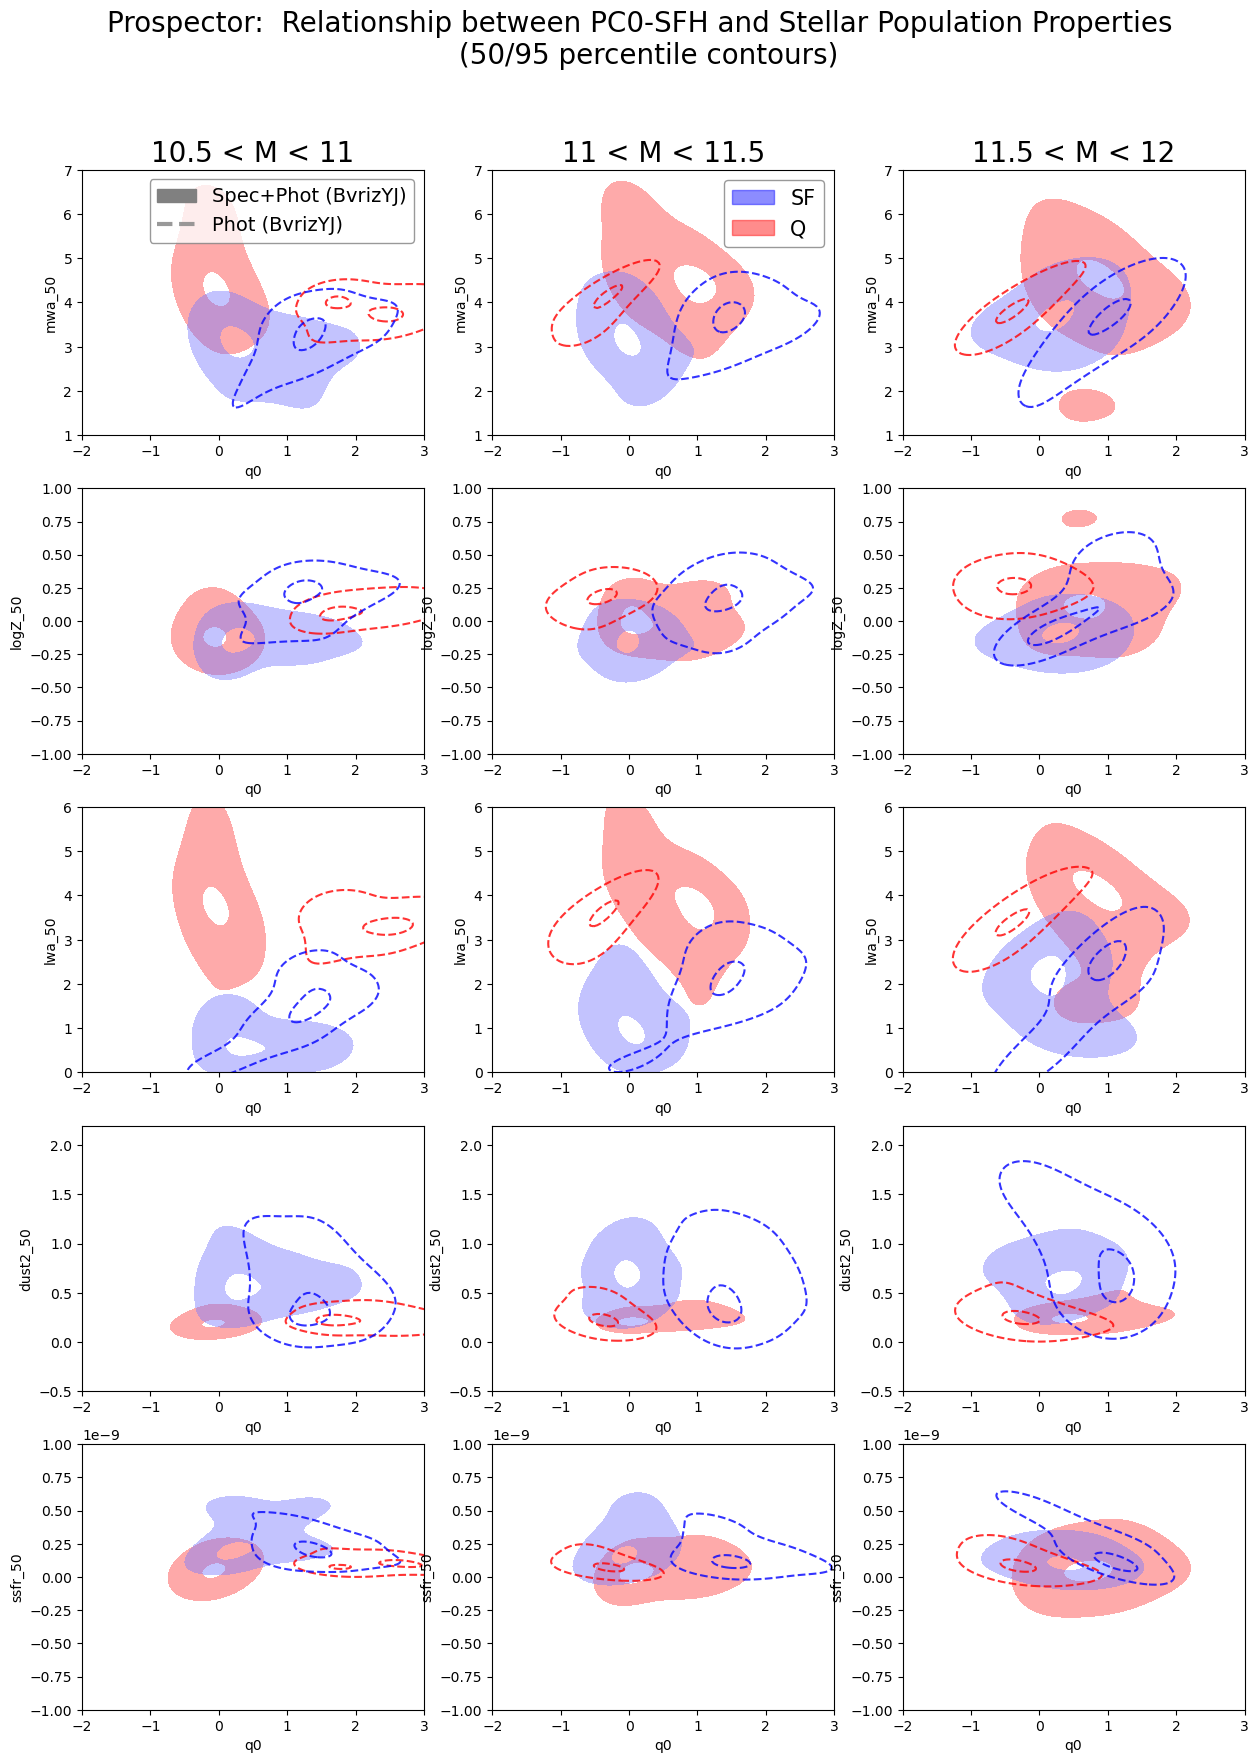

In [158]:
import seaborn as sns

fig, axes = plt.subplots(5,3,figsize=(15,20),sharex=False)
ax = axes.flatten()
levels = [0.5,.95]
# colors=['c','pink','forestgreen']
colors=['blue','red']

q = 'q0'

qxp1 = (qq1[q])/np.std(qq1[q])
qx1 = (qq1s[q])/np.std(qq1s[q])
sfxp1 = (qs1[q])/np.std(qs1[q])
sfx1 = (qs1s[q])/np.std(qs1s[q])


qxp2 = (qq2[q])/np.std(qq2[q])
qx2 = (qq2s[q])/np.std(qq2s[q])
sfxp2 = (qs2[q])/np.std(qs2[q])
sfx2 = (qs2s[q])/np.std(qs2s[q])

qxp3 = (qq3[q])/np.std(qq3[q])
qx3 = (qq3s[q])/np.std(qq3s[q])
sfxp3 = (qs3[q])/np.std(qs3[q])
sfx3 = (qs3s[q])/np.std(qs3s[q])

f = 15    

ax[0].set_title('10.5 < M < 11',fontsize=20)
ax[1].set_title('11 < M < 11.5',fontsize=20)
ax[2].set_title('11.5 < M < 12',fontsize=20)

# tform 50 ===========

ax[0].set_xlim(-2,3)
ax[0].set_ylim(1,7)

ax[1].set_xlim(-2,3)
ax[1].set_ylim(1,7)

ax[2].set_xlim(-2,3)
ax[2].set_ylim(1,7)

prop = 'mwa_50'
alpha = 0.45
alphap = 0.8

sns.kdeplot(x=qxp1, y=qq1[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[0], alpha=alphap)
sns.kdeplot(x=qx1, y=qq1s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[0], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp1, y=qs1[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[0], alpha=alphap)
sns.kdeplot(x=sfx1, y=qs1s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[0], alpha=alpha,fill=True)

sns.kdeplot(x=qxp2, y=qq2[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[1], alpha=alphap)
sns.kdeplot(x=qx2, y=qq2s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[1], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp2, y=qs2[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[1], alpha=alphap)
sns.kdeplot(x=sfx2, y=qs2s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[1], alpha=alpha,fill=True)

sns.kdeplot(x=qxp3, y=qq3[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[2], alpha=alphap)
sns.kdeplot(x=qx3, y=qq3s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[2], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp3, y=qs3[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[2], alpha=alphap)
sns.kdeplot(x=sfx3, y=qs3s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[2], alpha=alpha,fill=True)


# Zform 50 ===========

ax[3].set_xlim(-2,3)
ax[3].set_ylim(-1,1)

ax[4].set_xlim(-2,3)
ax[4].set_ylim(-1,1)

ax[5].set_xlim(-2,3)
ax[5].set_ylim(-1,1)

prop = 'logZ_50'

sns.kdeplot(x=qxp1, y=qq1[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[3], alpha=alphap)
sns.kdeplot(x=qx1, y=qq1s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[3], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp1, y=qs1[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[3], alpha=alphap)
sns.kdeplot(x=sfx1, y=qs1s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[3], alpha=alpha,fill=True)

sns.kdeplot(x=qxp2, y=qq2[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[4], alpha=alphap)
sns.kdeplot(x=qx2, y=qq2s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[4], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp2, y=qs2[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[4], alpha=alphap)
sns.kdeplot(x=sfx2, y=qs2s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[4], alpha=alpha,fill=True)

sns.kdeplot(x=qxp3, y=qq3[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[5], alpha=alphap)
sns.kdeplot(x=qx3, y=qq3s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[5], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp3, y=qs3[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[5], alpha=alphap)
sns.kdeplot(x=sfx3, y=qs3s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[5], alpha=alpha,fill=True)


# lwage 50 ===========

ax[6].set_xlim(-2,3)
ax[6].set_ylim(0,6)

ax[7].set_xlim(-2,3)
ax[7].set_ylim(0,6)

ax[8].set_xlim(-2,3)
ax[8].set_ylim(0,6)

prop = 'lwa_50'

sns.kdeplot(x=qxp1, y=qq1[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[6], alpha=alphap)
sns.kdeplot(x=qx1, y=qq1s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[6], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp1, y=qs1[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[6], alpha=alphap)
sns.kdeplot(x=sfx1, y=qs1s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[6], alpha=alpha,fill=True)

sns.kdeplot(x=qxp2, y=qq2[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[7], alpha=alphap)
sns.kdeplot(x=qx2, y=qq2s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[7], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp2, y=qs2[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[7], alpha=alphap)
sns.kdeplot(x=sfx2, y=qs2s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[7], alpha=alpha,fill=True)

sns.kdeplot(x=qxp3, y=qq3[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[8], alpha=alphap)
sns.kdeplot(x=qx3, y=qq3s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[8], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp3, y=qs3[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[8], alpha=alphap)
sns.kdeplot(x=sfx3, y=qs3s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[8], alpha=alpha,fill=True)


# Av 50 ===========

ax[9].set_xlim(-2,3)
ax[9].set_ylim(-0.5,2.2)

ax[10].set_xlim(-2,3)
ax[10].set_ylim(-0.5,2.2)

ax[11].set_xlim(-2,3)
ax[11].set_ylim(-0.5,2.2)

prop = 'dust2_50'

sns.kdeplot(x=qxp1, y=qq1[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[9], alpha=alphap)
sns.kdeplot(x=qx1, y=qq1s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[9], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp1, y=qs1[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[9], alpha=alphap)
sns.kdeplot(x=sfx1, y=qs1s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[9], alpha=alpha,fill=True)

sns.kdeplot(x=qxp2, y=qq2[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[10], alpha=alphap)
sns.kdeplot(x=qx2, y=qq2s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[10], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp2, y=qs2[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[10], alpha=alphap)
sns.kdeplot(x=sfx2, y=qs2s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[10], alpha=alpha,fill=True)

sns.kdeplot(x=qxp3, y=qq3[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[11], alpha=alphap)
sns.kdeplot(x=qx3, y=qq3s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[11], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp3, y=qs3[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[11], alpha=alphap)
sns.kdeplot(x=sfx3, y=qs3s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[11], alpha=alpha,fill=True)


# sfr 50 ===========

ax[12].set_xlim(-2,3)
ax[12].set_ylim(-1e-9,1e-9)

ax[13].set_xlim(-2,3)
ax[13].set_ylim(-1e-9,1e-9)

ax[14].set_xlim(-2,3)
ax[14].set_ylim(-1e-9,1e-9)

prop = 'ssfr_50'

sns.kdeplot(x=qxp1, y=qq1[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[12], alpha=alphap)
sns.kdeplot(x=qx1, y=qq1s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[12], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp1, y=qs1[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[12], alpha=alphap)
sns.kdeplot(x=sfx1, y=qs1s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[12], alpha=alpha,fill=True)

sns.kdeplot(x=qxp2, y=qq2[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[13], alpha=alphap)
sns.kdeplot(x=qx2, y=qq2s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[13], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp2, y=qs2[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[13], alpha=alphap)
sns.kdeplot(x=sfx2, y=qs2s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[13], alpha=alpha,fill=True)

sns.kdeplot(x=qxp3, y=qq3[prop],levels=levels,color=colors[1],linestyles="--",ax=ax[14], alpha=alphap)
sns.kdeplot(x=qx3, y=qq3s[prop],levels=levels,color=colors[1],linestyles="-",ax=ax[14], alpha=alpha,fill=True)
sns.kdeplot(x=sfxp3, y=qs3[prop],levels=levels,color=colors[0],linestyles="--",ax=ax[14], alpha=alphap)
sns.kdeplot(x=sfx3, y=qs3s[prop],levels=levels,color=colors[0],linestyles="-",ax=ax[14], alpha=alpha,fill=True)


fig.suptitle('Prospector:  Relationship between PC0-SFH and Stellar Population Properties \n (50/95 percentile contours)',fontsize=20,y=0.96)

handles, labels = plt.gca().get_legend_handles_labels()
patch0 = mpatches.Patch(color='grey', label='Spec+Phot (BvrizYJ)')
line2 = Line2D([0], [0], label='Phot (BvrizYJ)', color='grey',linestyle='dashed',linewidth = 3,alpha=0.8)
handles.extend([patch0,line2])
leg = ax[0].legend(handles=handles,fontsize=14,loc='upper right',markerscale=1.3,frameon=True,edgecolor='grey')

handles, labels = plt.gca().get_legend_handles_labels()
patch1 = mpatches.Patch(color=colors[0], label='SF', alpha=alpha)
patch2 = mpatches.Patch(color=colors[1], label='Q' , alpha=alpha)
handles.extend([patch1,patch2])
leg = ax[1].legend(handles=handles,fontsize=15,loc='upper right',markerscale=1.3,frameon=True,edgecolor='grey')


# fig.savefig('/Users/yashakaushal/Documents/my_papers/paper2/plots/uglyplots/prosp_q0_stelpops_1.pdf',bbox_inches='tight')


### NOTE - 

1. For mass-weighted ages (row1), photometric data shows positive correlation with q0 whereas spectrophotometric data suggests mostly anti-correlation. 
2. For stellar metallicites (row2), no strong correlations are seen with q0, some weak correlations exist for most massive systems.
3. For light-weighted ages (row3), low mass galaxies do not exhibit strong trends whereas massive galaxies show positive correlation from photometric data and negative correlation with spectro-photometric data. 
4. For dust content (row4), as expected, quiescent systems (red) show little to no correlation (as they mostly lack dust) where as star-forming systems show correlations with q0. 